# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **XGBoost** et **SHAP**.

# <span style="color:red"> ✨ Étape 2 - Préparez la donnée pour la modélisation</span>


# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [31]:
import os

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.pipeline  import Pipeline      # Enchaînement des transformations
from   sklearn.compose   import ColumnTransformer # Application par colonnes
from   sklearn.impute    import SimpleImputer # Gestion des valeurs manquantes
from   sklearn.preprocessing import (
    StandardScaler,                           # Normalisation des données
    RobustScaler,
    OneHotEncoder,                            # Encodage catégoriel binaire
    FunctionTransformer                       # Transformations personnalisées
)

# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [32]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
PREPROCESED_DIR  = Path("../data/processed")
REPORTS_DIR      = Path("../reports")

NB_OBSERVATIONS_SIRH_RAW    = None
NB_FEATURES_SIRH_RAW        = None

NB_OBSERVATIONS_EVALS_RAW   = None
NB_FEATURES_EVALS_RAW       = None

NB_OBSERVATIONS_SONDAGE_RAW = None
NB_FEATURES_SONDAGE_RAW     = None

# ============================================================================
# 1.5 CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET           = "attrition_binary"

FEATURE_TARGET_INITIAL   = "a_quitte_l_entreprise"
 

# Identifies dans l'etape precedent
THRESHOLD_MISSING_EXCESIF          = 99.9  # Over 100
THRESHOLD_NUMERICAL_REDONDANCE     = 0.90  # Over 1 

# --- LISTE DE COLUMNAS (Pour selection) ---
FEATURES_TO_REMOVE            = []  # COLS_IDENTIFIANTS + COLS_CONSTANT + COLS_MISSING_EXCESIF + self.COLS_REDONDANTS
COLS_IDENTIFIANTS             = ['id', 'id_employee', 'eval_number', 'code_sondage' ] 
COLS_CONSTANT                 = []  
COLS_MISSING_EXCESIF          = [] 
COLS_REDONDANTS               = [] 

# --- CATEGORICAL  ---
COLS_CATEGORICAL              = []  # Todas las categóricas detectadas
COLS_ONE_HOT_ENCODING         = []
COLS_BINARY_ENCODING          = []
COLS_TARGET_ENCODING          = []
COLS_TARGET_ADVANCED_ENCODING = []

# --- NUMERICAL ---
COLS_NUMERICAL                = []  # Todas las numéricas detectadas
COLS_TO_LOG                   = []  # Candidatas a log(1+x) par asymétrie
COLS_TO_ROBUST                = []
COLS_STANDARD                 = []

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si vous avez beaucoup de lignes, vous pouvez contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...: {FEATURE_TARGET}")
print(f"  COLS_IDENTIFIANTS.....)...: {COLS_IDENTIFIANTS}")
print("  Status....................: ✅ Configuration prête")
print("============================================================================")



PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...: attrition_binary
  COLS_IDENTIFIANTS.....)...: ['id', 'id_employee', 'eval_number', 'code_sondage']
  Status....................: ✅ Configuration prête


# Étape 2 - Préparez la donnée pour la modélisation

## ❇️ LOAD AND EXPLORE DATASET MERGED

In [33]:
# 1. Chargement des fichiers
df_merged    = pd.read_parquet(INTERIM_DATA_DIR / "df_merged_eda.parquet")
print(df_merged.info())                                       # Vérification des types Dtype (int, float, object)
display(df_merged.head(3))   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travailless                  1470 non-null   int64 
 9   annee_experience_totale                    1470 non-null   int64 
 10  annees_dans_l_entreprise            

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,attrition_binary
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,0
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,1,4,2,2,Autre,Y,Occasionnel,0,0,1


## ⬇️ Import Classe auxiliare pour analyse (DataCleaner)

In [34]:
# ==================================================================================================
# INITIALISATION DU MOTEUR DE NETTOYAGE (DATA CLEANING)
# ==================================================================================================

# Importation de la classe personnalisée d'ingénierie des données
# Cette classe encapsule les règles métier spécifiques au dataset de Seattle.
from DataCleaner  import DataCleaner                # Module de nettoyage propriétaire

# Initialisation du nettoyeur global
# verbose=True permet d'éditer un rapport détaillé des transformations effectuées.
cleaner           = DataCleaner(
                           df      = df_merged,      # Source des données brutes
                           verbose = True              # Activation des logs détaillés
)

# --------------------------------------------------------------------------------------------------
# RAPPORT D'ÉTAT DU NETTOYEUR
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("INSTANCIATION DU MOTEUR DE NETTOYAGE")
print("==================================================================================================")
print(f"  Objet créé............: {type(cleaner).__name__}")
print(f"  Mode verbeux..........: Activé (Diagnostic temps réel)")
print(f"  Source de données.....: dataset_raw (ID: {id(df_merged)})")
print(f"  Statut................: ✅ Prêt pour l'étape de transformation")
print("==================================================================================================\n")


INSTANCIATION DU MOTEUR DE NETTOYAGE
  Objet créé............: DataCleaner
  Mode verbeux..........: Activé (Diagnostic temps réel)
  Source de données.....: dataset_raw (ID: 2645659273648)
  Statut................: ✅ Prêt pour l'étape de transformation



## 📗 Creation du un META-DICTIONAIRE 

In [35]:
# Dictionnaire de métadonnées pour les graphiques - Dataset Employés RH
meta_dict = {
    # === IDENTIFIANTS ===
    "id_employee"                                : "Identifiant unique de l'employé",
    "id"                                         : "Identifiant secondaire",
    "code_sondage"                               : "Code du sondage RH",
    
    # === DONNÉES DÉMOGRAPHIQUES ===
    "age"                                        : "Âge de l'employé (années)",
    "genre"                                      : "Genre de l'employé",
    "statut_marital"                             : "Statut matrimonial",
    "ayant_enfants"                              : "A des enfants (Oui/Non)",
    "distance_domicile_travail"                  : "Distance domicile-travail (km)",
    
    # === ÉDUCATION ET FORMATION ===
    "niveau_education"                           : "Niveau d'éducation (1-5)",
    "domaine_etude"                              : "Domaine d'études",
    "nb_formations_suivies"                      : "Nombre de formations suivies",
    
    # === POSTE ET DÉPARTEMENT ===
    "departement"                                : "Département de travail",
    "poste"                                      : "Intitulé du poste",
    "niveau_hierarchique_poste"                  : "Niveau hiérarchique du poste",
    
    # === RÉMUNÉRATION ===
    "revenu_mensuel"                             : "Revenu mensuel (€)",
    "augementation_salaire_precedente"           : "Augmentation salariale précédente (%)",
    
    # === EXPÉRIENCE PROFESSIONNELLE ===
    "nombre_experiences_precedentes"             : "Nombre d'employeurs précédents",
    "annee_experience_totale"                    : "Années d'expérience totale",
    "annees_dans_l_entreprise"                   : "Ancienneté dans l'entreprise (années)",
    "annees_dans_le_poste_actuel"                : "Ancienneté dans le poste actuel (années)",
    "annees_depuis_la_derniere_promotion"        : "Années depuis la dernière promotion",
    
    # === TEMPS DE TRAVAIL ===
    "nombre_heures_travailless"                  : "Nombre d'heures de travail hebdomadaires",
    "heure_supplementaires"                      : "Fait des heures supplémentaires (Oui/Non)",
    "frequence_deplacement"                      : "Fréquence des déplacements professionnels",
    
    # === ÉVALUATIONS ET PERFORMANCE ===
    "note_evaluation_precedente"                 : "Note de l'évaluation précédente (1-100)",
    "note_evaluation_actuelle"                   : "Note de l'évaluation actuelle (1-100)",
    "eval_number"                                : "Numéro/Type d'évaluation",
    
    # === SATISFACTION AU TRAVAIL ===
    "satisfaction_employee_environnement"        : "Satisfaction : environnement de travail (1-4)",
    "satisfaction_employee_nature_travail"       : "Satisfaction : nature du travail (1-4)",
    "satisfaction_employee_equipe"               : "Satisfaction : équipe de travail (1-4)",
    "satisfaction_employee_equilibre_pro_perso"  : "Satisfaction : équilibre vie pro/perso (1-4)",
    
    # === ENGAGEMENT ET PARTICIPATION ===
    "nombre_participation_pee"                   : "Nombre de participations au PEE",
    
    # === MANAGEMENT ===
    "nombre_employee_sous_responsabilite"        : "Nombre d'employés sous sa responsabilité",
    "annes_sous_responsable_actuel"              : "Années sous le responsable actuel",
    
    # === VARIABLE CIBLE ===
    "a_quitte_l_entreprise"                      : "A quitté l'entreprise (Oui/Non) - TARGET"
}


In [36]:
meta_dict_enrichi = {
    # === VARIABLE CIBLE ===
    "a_quitte_l_entreprise"                     : {
        "description"        : "A quitté l'entreprise (Variable cible)",
        "type"               : "object",
        "categorie"          : "Target",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "VARIABLE CIBLE - Deja codifiqué dans la phase EDA",
        "valeurs_possibles"  : ["Oui", "Non"],
    },
    
    # === IDENTIFIANTS ===
    "id"                                        : {
        "description"        : "Identifiant secondaire",
        "type"               : "object",
        "categorie"          : "Identifiant",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "Identifiant utilisé dans le merge"
    },
    "id_employee"                               : {
        "description"        : "Identifiant unique de l'employé",
        "type"               : "int64",
        "categorie"          : "Identifiant",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "Identifiant technique sans valeur prédictive (df_sirh)"
    },
    "code_sondage"                              : {
        "description"        : "Code du sondage RH",
        "type"               : "int64",
        "categorie"          : "Identifiant",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "Identifiant de sondage sans valeur prédictive (df_sondage)"
    },
    "eval_number"                               : {
        "description"        : "Numéro ou type d'évaluation",
        "type"               : "object",
        "categorie"          : "Identifiant",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "Identifiant de sondage sans valeur prédictive (evals)"
    },

    # === CONSTANTS ===

    "nombre_employee_sous_responsabilite"       : {
        "description"        : "Nombre d'employés sous sa responsabilité",
        "type"               : "int64",
        "categorie"          : "Management",
        "unite"              : "nombre",
        "a_supprimer"        : True,
        "raison_suppression" : "Constant"
    },
    "nombre_heures_travailless"                 : {
        "description"        : "Nombre d'heures de travail hebdomadaires",
        "type"               : "int64",
        "categorie"          : "Temps de travail",
        "unite"              : "heures/semaine",
        "a_supprimer"        : True,
        "raison_suppression" : "Constant"
    },

    "ayant_enfants"                             : {
        "description"        : "A des enfants",
        "type"               : "object",
        "categorie"          : "Démographique",
        "unite"              : None,
        "a_supprimer"        : True,
        "raison_suppression" : "Constant"
    },
    # === DONNÉES DÉMOGRAPHIQUES ===
    "age"                                       : {
        "description"        : "Âge de l'employé",
        "type"               : "int64",
        "categorie"          : "Démographique",
        "unite"              : "années",
        "a_supprimer"        : False,
    },
    "genre"                                     : {
        "description"        : "Genre de l'employé",
        "type"               : "object",
        "categorie"          : "Démographique",
        "unite"              : None,
        "a_supprimer"        : False,
    },
    "statut_marital"                            : {
        "description"        : "Statut matrimonial",
        "type"               : "object",
        "categorie"          : "Démographique",
        "unite"              : None,
        "a_supprimer"        : False,
    },

    "distance_domicile_travail"                 : {
        "description"        : "Distance entre domicile et travail",
        "type"               : "int64",
        "categorie"          : "Démographique",
        "unite"              : "km",
        "a_supprimer"        : False,
    },

    # === ÉDUCATION ET FORMATION ===
    "niveau_education"                          : {
        "description"        : "Niveau d'éducation",
        "type"               : "int64",
        "categorie"          : "Éducation",
        "unite"              : "niveau (1-5)",
        "a_supprimer"        : False,
        "encodage_necessaire": False,
        "note"               : "Variable ordinale déjà encodée"
    },
    "domaine_etude"                             : {
        "description"        : "Domaine d'études principal",
        "type"               : "object",
        "categorie"          : "Éducation",
        "unite"              : None,
        "a_supprimer"        : False,
    },
    "nb_formations_suivies"                     : {
        "description"        : "Nombre de formations suivies dans l'entreprise",
        "type"               : "int64",
        "categorie"          : "Éducation",
        "unite"              : "nombre",
        "a_supprimer"        : False,
    },

    # === POSTE ET DÉPARTEMENT ===
    "departement"                               : {
        "description"        : "Département de travail",
        "type"               : "object",
        "categorie"          : "Poste",
        "unite"              : None,
        "a_supprimer"        : False,
    },
    "poste"                                     : {
        "description"        : "Intitulé du poste occupé",
        "type"               : "object",
        "categorie"          : "Poste",
        "unite"              : None,
        "a_supprimer"        : False,
    },
    "niveau_hierarchique_poste"                 : {
        "description"        : "Niveau hiérarchique du poste",
        "type"               : "int64",
        "categorie"          : "Poste",
        "unite"              : "niveau (1-5)",
        "a_supprimer"        : False,
    },

    # === RÉMUNÉRATION ===
    "revenu_mensuel"                            : {
        "description"        : "Revenu mensuel brut",
        "type"               : "int64",
        "categorie"          : "Rémunération",
        "unite"              : "€",
        "a_supprimer"        : False,
    },
    "augementation_salaire_precedente"          : {
        "description"        : "Pourcentage d'augmentation salariale précédente",
        "type"               : "object",
        "categorie"          : "Rémunération",
        "unite"              : "%",
        "a_supprimer"        : False,
    },

    # === EXPÉRIENCE PROFESSIONNELLE ===
    "nombre_experiences_precedentes"            : {
        "description"        : "Nombre d'employeurs précédents",
        "type"               : "int64",
        "categorie"          : "Expérience",
        "unite"              : "nombre",
        "a_supprimer"        : False,
    },
    "annee_experience_totale"                   : {
        "description"        : "Années d'expérience professionnelle totale",
        "type"               : "int64",
        "categorie"          : "Expérience",
        "unite"              : "années",
        "a_supprimer"        : False,
    },
    "annees_dans_l_entreprise"                  : {
        "description"        : "Ancienneté dans l'entreprise",
        "type"               : "int64",
        "categorie"          : "Expérience",
        "unite"              : "années",
        "a_supprimer"        : False,
    },
    "annees_dans_le_poste_actuel"               : {
        "description"        : "Ancienneté dans le poste actuel",
        "type"               : "int64",
        "categorie"          : "Expérience",
        "unite"              : "années",
        "a_supprimer"        : False,
    },
    "annees_depuis_la_derniere_promotion"       : {
        "description"        : "Années écoulées depuis la dernière promotion",
        "type"               : "int64",
        "categorie"          : "Expérience",
        "unite"              : "années",
        "a_supprimer"        : False,
    },

    # === TEMPS DE TRAVAIL ===

    "heure_supplementaires"                     : {
        "description"        : "Fait des heures supplémentaires",
        "type"               : "object",
        "categorie"          : "Temps de travail",
        "unite"              : None,
        "a_supprimer"        : False,
    },
    "frequence_deplacement"                     : {
        "description"        : "Fréquence des déplacements professionnels",
        "type"               : "object",
        "categorie"          : "Temps de travail",
        "unite"              : None,
        "a_supprimer"        : False,
    },

    # === ÉVALUATIONS ET PERFORMANCE ===
    "note_evaluation_precedente"                : {
        "description"        : "Note de l'évaluation précédente",
        "type"               : "int64",
        "categorie"          : "Performance",
        "unite"              : "score (1-100)",
        "a_supprimer"        : False,
        "encodage_necessaire": False
    },
    "note_evaluation_actuelle"                  : {
        "description"        : "Note de l'évaluation actuelle",
        "type"               : "int64",
        "categorie"          : "Performance",
        "unite"              : "score (1-100)",
        "a_supprimer"        : False,
    },


    # === SATISFACTION AU TRAVAIL ===
    "satisfaction_employee_environnement"       : {
        "description"        : "Satisfaction vis-à-vis de l'environnement de travail",
        "type"               : "int64",
        "categorie"          : "Satisfaction",
        "unite"              : "score (1-4)",
        "a_supprimer"        : False,
    },
    "satisfaction_employee_nature_travail"      : {
        "description"        : "Satisfaction vis-à-vis de la nature du travail",
        "type"               : "int64",
        "categorie"          : "Satisfaction",
        "unite"              : "score (1-4)",
        "a_supprimer"        : False,
    },
    "satisfaction_employee_equipe"              : {
        "description"        : "Satisfaction vis-à-vis de l'équipe de travail",
        "type"               : "int64",
        "categorie"          : "Satisfaction",
        "unite"              : "score (1-4)",
        "a_supprimer"        : False,
    },
    "satisfaction_employee_equilibre_pro_perso": {
        "description"        : "Satisfaction vis-à-vis de l'équilibre vie professionnelle/personnelle",
        "type"               : "int64",
        "categorie"          : "Satisfaction",
        "unite"              : "score (1-4)",
        "a_supprimer"        : False,
    },

    # === ENGAGEMENT ET PARTICIPATION ===
    "nombre_participation_pee"                  : {
        "description"        : "Nombre de participations au Plan d'Épargne Entreprise",
        "type"               : "int64",
        "categorie"          : "Engagement",
        "unite"              : "nombre",
        "a_supprimer"        : False,
    },

    # === MANAGEMENT ===

    "annes_sous_responsable_actuel"             : {
        "description"        : "Années passées sous le responsable actuel",
        "type"               : "int64",
        "categorie"          : "Management",
        "unite"              : "années",
        "a_supprimer"        : False,
    }


}

# ========================================================================
# FONCTIONS UTILITAIRES
# ========================================================================

def afficher_metadata(colonne):
    """Affiche les métadonnées d'une colonne"""
    if colonne in meta_dict_enrichi:
        meta = meta_dict_enrichi[colonne]
        print(f"\n{'='*60}")
        print(f"MÉTADONNÉES : {colonne}")
        print(f"{'='*60}")
        for key, value in meta.items():
            print(f"{key:25s} : {value}")
    else:
        print(f"❌ Colonne '{colonne}' non trouvée dans le dictionnaire")


def lister_colonnes_par_categorie(categorie):
    """Liste toutes les colonnes d'une catégorie donnée"""
    colonnes = [
        col for col, meta in meta_dict_enrichi.items() 
        if meta['categorie'] == categorie
    ]
    return colonnes


def lister_colonnes_a_encoder():
    """Liste toutes les colonnes nécessitant un encodage"""
    colonnes = [
        (col, meta['type_encodage']) 
        for col, meta in meta_dict_enrichi.items() 
        if meta.get('encodage_necessaire', False)
    ]
    return colonnes


def lister_colonnes_a_supprimer():
    """Liste toutes les colonnes à supprimer"""
    colonnes = [
        (col, meta.get('raison_suppression', 'Non spécifiée')) 
        for col, meta in meta_dict_enrichi.items() 
        if meta.get('a_supprimer', False)
    ]
    return colonnes

#### Identifier colonnes par types

In [37]:
# 1. Obtener la clasificación técnica real del DataFrame actual
# (Este es el método que ya tenías que devuelve el dict de listas)
types_cols = cleaner._identifier_colonnes_par_types()


🔄 Transformation binaire : heure_supplementaires ({'Non', 'Oui'} -> 0/1)
🔄 Transformation binaire : a_quitte_l_entreprise ({'Non', 'Oui'} -> 0/1)


#### Actualiser le meta_dict 

In [38]:
# 2. Enriquecer el meta_dict y mostrar el listado clasificado
# Nota: Pasamos el meta_dict_enrichi que definiste al principio
cleaner.enriquecer_y_clasificar_meta(cleaner.df,meta_dict_enrichi, types_cols)



--- 🗑️ COLUMNAS A SUPRIMIR (8) ---
  COLONNE                                       | ACTION/ENC           | NOTE / CONTENU
  ---------------------------------------------------------------------------------------
• a_quitte_l_entreprise                         | ❌ Suppresion         | VARIABLE CIBLE - Deja codifiqué dans la phase EDA
• id                                            | ❌ Suppresion         | Identifiant utilisé dans le merge
• id_employee                                   | ❌ Suppresion         | Identifiant technique sans valeur prédictive (df_sirh)
• code_sondage                                  | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (df_sondage)
• eval_number                                   | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (evals)
• nombre_employee_sous_responsabilite           | ❌ Suppresion         | Constant
• nombre_heures_travailless                     | ❌ Suppresion         | Constant
• aya

## 🗑️ STEP 1. Nettoyage Initial et Élimination

### Conversion de Percents

In [39]:
cleaner.df, meta_dict_enrichi = cleaner.convert_percentages_to_float(cleaner.df, meta_dict_enrichi)

📊 Transformation : augementation_salaire_precedente (Categoriel % -> Numerique)


### Indetification des Identifiants

In [40]:
cleaner.COLS_IDENTIFIANTS = COLS_IDENTIFIANTS
cleaner.COLS_IDENTIFIANTS

['id', 'id_employee', 'eval_number', 'code_sondage']

### Indetification des Constants

In [41]:
variance_res          = cleaner.constant_columns_analysis(cleaner.df)
COLS_CONSTANT         = variance_res['constant_cols']
cleaner.COLS_CONSTANT = COLS_CONSTANT
cleaner.COLS_CONSTANT

['nombre_heures_travailless',
 'nombre_employee_sous_responsabilite',
 'ayant_enfants']

### Identification des Manquants Excessifs

In [42]:
print("===============================================================================")
print(" TEST 1: missing_summary                                                       ")
print(" Génère un résumé statistique des valeurs manquantes par colonne.              ")
print("===============================================================================\n")
df_miss, cols_excessives = cleaner.missing_summary(cleaner.df, threshold=THRESHOLD_MISSING_EXCESIF)

# 2. Control de ejecución: Solo si hay datos faltantes
if not df_miss.empty:
    print(df_miss)

    COLS_MISSING_EXCESIF = cleaner.COLS_MISSING_EXCESIF = cols_excessives
    
    print("===============================================================================")
    print(" TEST 2: missing_heatmap                                                       ")
    print(" Crée une cartographie visuelle des patterns de valeurs manquantes.            ")
    print("===============================================================================\n")
    fig = cleaner.missing_heatmap(cleaner.df)
    plt.show()
    
    print("===============================================================================")
    print(" TEST 3: missing_by_type                                                       ")
    print(" Crée une cartographie visuelle des patterns de valeurs manquantes.            ")
    print("===============================================================================\n")
    num_miss, cat_miss = cleaner.missing_by_type(cleaner.df)
    print("Numériques:\n", num_miss)
    print("Catégorielles:\n", cat_miss)
    
    print("===============================================================================")
    print(" TEST 4: missing_threshold_filter                                              ")
    print(" Crée une cartographie visuelle des patterns de valeurs manquantes.            ")
    print("===============================================================================\n")
    print(cleaner.missing_threshold_filter(cleaner.df, threshold=THRESHOLD_MISSING_EXCESIF, return_type='dataframe'))
else:
    print("✅ AUCUNE DONNÉE MANQUANTE DÉTECTÉE")
    print("Le dataset est complet. Le heatmap n'est pas nécessaire.")

cleaner.COLS_MISSING_EXCESIF

 TEST 1: missing_summary                                                       
 Génère un résumé statistique des valeurs manquantes par colonne.              

✅ AUCUNE DONNÉE MANQUANTE DÉTECTÉE
Le dataset est complet. Le heatmap n'est pas nécessaire.


[]

### 🗑️ Suppression des Colonnes

In [43]:
cleaner.FEATURES_TO_REMOVE  =  FEATURES_TO_REMOVE  = COLS_IDENTIFIANTS + COLS_CONSTANT + COLS_MISSING_EXCESIF + COLS_REDONDANTS

cleaner.df = cleaner.supprimer_colonnes_specifiques(cleaner.df,FEATURES_TO_REMOVE)



✓ ACTION : Suppression de 7 colonnes spécifiques.
  DÉTAIL : id, id_employee, eval_number, code_sondage, nombre_heures_travailless, nombre_employee_sous_responsabilite, ayant_enfants


## 🔹 STEP 2. Codification Catégorielle

### Identification des Categoriales Redondants

#### analyse_contingence_target

In [44]:
cleaner.COLS_CATEGORICAL = cleaner.df.select_dtypes(include=['object', 'category']).columns.tolist()
cleaner.COLS_CATEGORICAL

['genre',
 'statut_marital',
 'departement',
 'poste',
 'domaine_etude',
 'frequence_deplacement']

In [45]:
from scipy.stats import chi2_contingency
import pandas as pd

def analyse_contingence_target(df, cols_cat, target):
    results = []
    
    print(f"\n{'🧪 ANALYSE DE DÉPENDANCE (Test du Khi-Deux)':^80}")
    print(f"{'Cible : ' + target:^80}")
    print("-" * 85)
    print(f"  {'COLONNE':<35} | {'P-VALUE':<12} | {'DÉPENDANCE':<15} | {'ÉTAT'}")
    print("-" * 85)

    for col in cols_cat:
        if col == target: continue
        
        # 1. Créer la table de contingence
        contingency_table = pd.crosstab(df[col], df[target])
        
        # 2. Exécuter le test du Khi-Deux
        # chi2: estadística, p: p-value, dof: grados de libertad
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # 3. Interprétation
        est_dependant = "OUI" if p < 0.05 else "NON"
        force = "🟢 Forte" if p < 0.001 else ("🟡 Significative" if p < 0.05 else "⚪ Faible/Nulle")
        
        print(f"• {col:<33} | {p:<12.4e} | {est_dependant:<15} | {force}")
        
        results.append({
            'colonne': col,
            'p_value': p,
            'dependance': est_dependant,
            'force': force
        })

    print("-" * 85)
    return pd.DataFrame(results)

# Ejecución
df_results = analyse_contingence_target(cleaner.df, cleaner.COLS_CATEGORICAL, FEATURE_TARGET_INITIAL)


                   🧪 ANALYSE DE DÉPENDANCE (Test du Khi-Deux)                   
                         Cible : a_quitte_l_entreprise                          
-------------------------------------------------------------------------------------
  COLONNE                             | P-VALUE      | DÉPENDANCE      | ÉTAT
-------------------------------------------------------------------------------------
• genre                             | 2.9057e-01   | NON             | ⚪ Faible/Nulle
• statut_marital                    | 9.4555e-11   | OUI             | 🟢 Forte
• departement                       | 4.5256e-03   | OUI             | 🟡 Significative
• poste                             | 2.7525e-15   | OUI             | 🟢 Forte
• domaine_etude                     | 6.7740e-03   | OUI             | 🟡 Significative
• frequence_deplacement             | 5.6086e-06   | OUI             | 🟢 Forte
-------------------------------------------------------------------------------------


#### analyse_theorique_et_heatmap

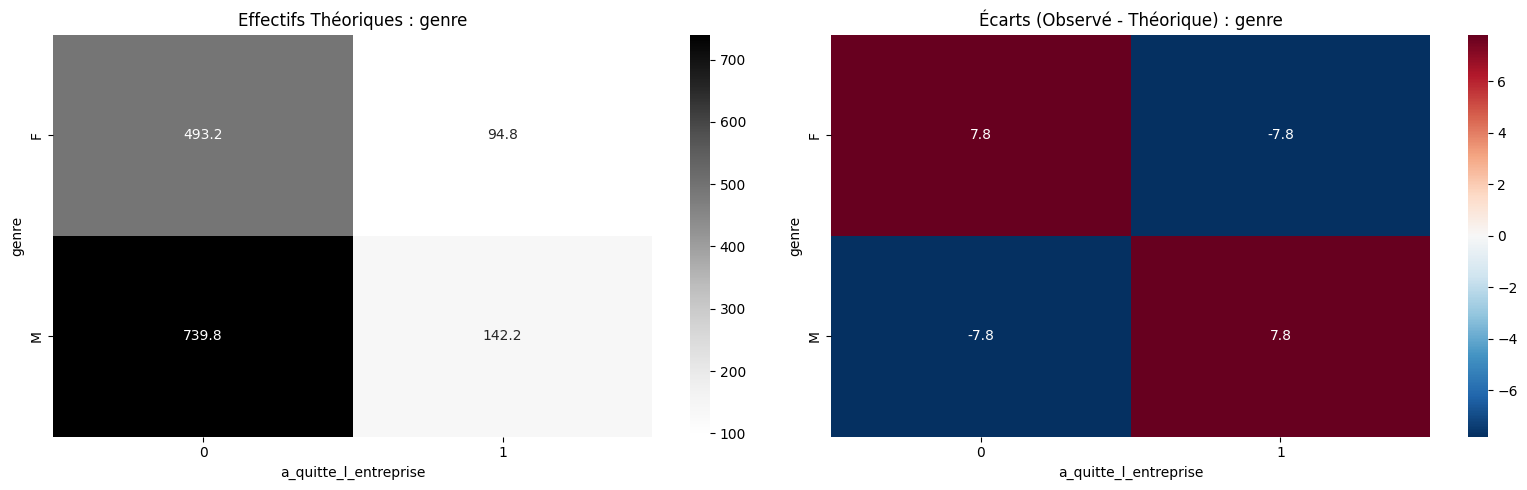

📊 Tableau de contingence théorique pour genre (Hasard pur) :


a_quitte_l_entreprise,0,1
genre,,
F,493.2,94.8
M,739.8,142.2


--------------------------------------------------------------------------------


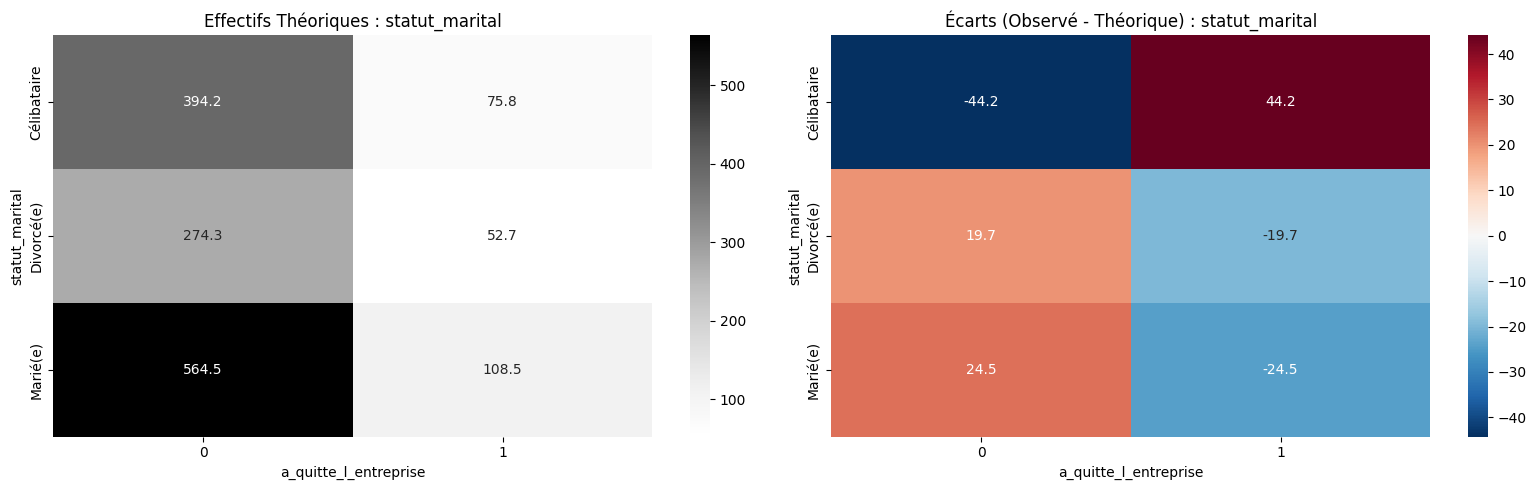

📊 Tableau de contingence théorique pour statut_marital (Hasard pur) :


a_quitte_l_entreprise,0,1
statut_marital,,
Célibataire,394.2,75.8
Divorcé(e),274.3,52.7
Marié(e),564.5,108.5


--------------------------------------------------------------------------------


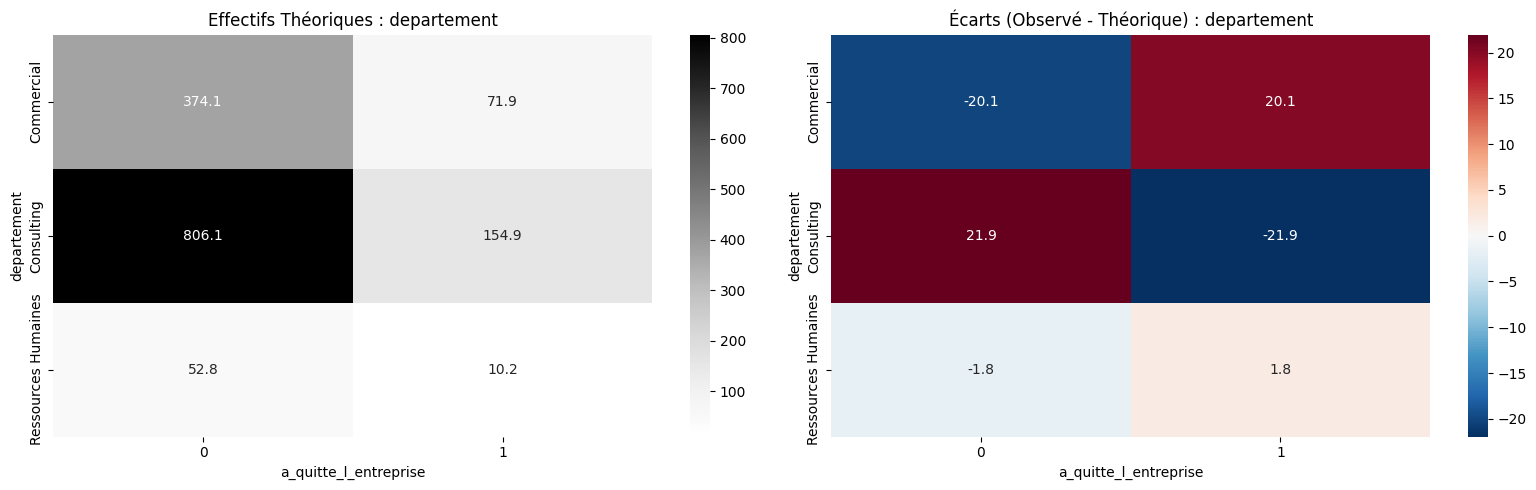

📊 Tableau de contingence théorique pour departement (Hasard pur) :


a_quitte_l_entreprise,0,1
departement,,
Commercial,374.1,71.9
Consulting,806.1,154.9
Ressources Humaines,52.8,10.2


--------------------------------------------------------------------------------


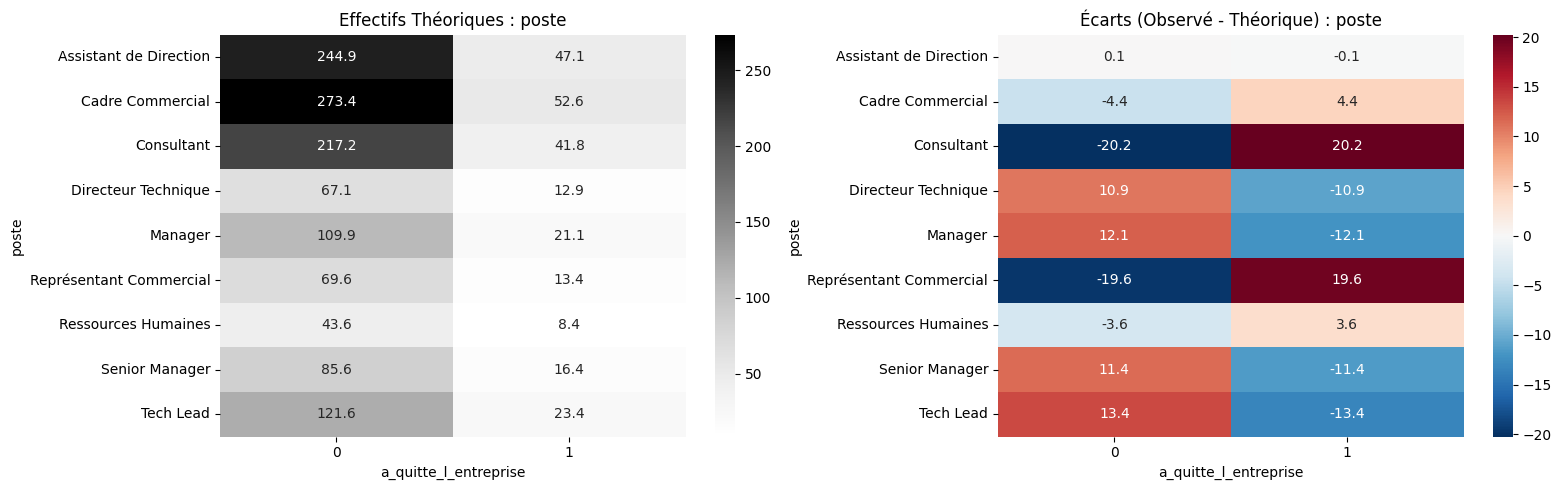

📊 Tableau de contingence théorique pour poste (Hasard pur) :


a_quitte_l_entreprise,0,1
poste,,
Assistant de Direction,244.9,47.1
Cadre Commercial,273.4,52.6
Consultant,217.2,41.8
Directeur Technique,67.1,12.9
Manager,109.9,21.1
Représentant Commercial,69.6,13.4
Ressources Humaines,43.6,8.4
Senior Manager,85.6,16.4
Tech Lead,121.6,23.4


--------------------------------------------------------------------------------


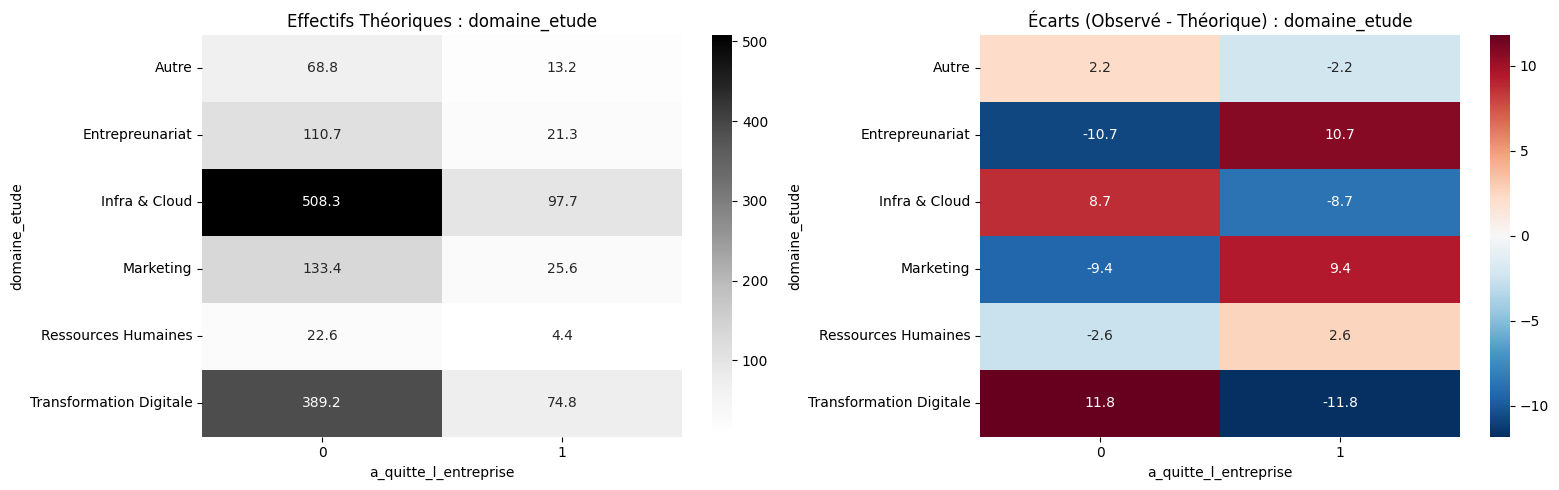

📊 Tableau de contingence théorique pour domaine_etude (Hasard pur) :


a_quitte_l_entreprise,0,1
domaine_etude,,
Autre,68.8,13.2
Entrepreunariat,110.7,21.3
Infra & Cloud,508.3,97.7
Marketing,133.4,25.6
Ressources Humaines,22.6,4.4
Transformation Digitale,389.2,74.8


--------------------------------------------------------------------------------


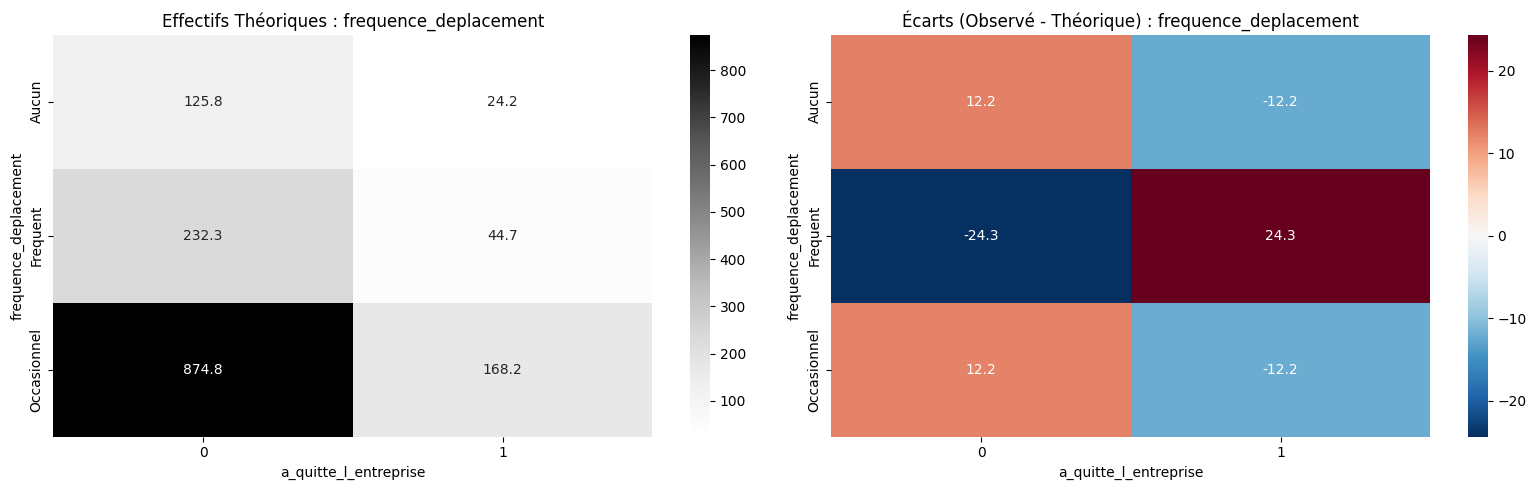

📊 Tableau de contingence théorique pour frequence_deplacement (Hasard pur) :


a_quitte_l_entreprise,0,1
frequence_deplacement,,
Aucun,125.8,24.2
Frequent,232.3,44.7
Occasionnel,874.8,168.2


--------------------------------------------------------------------------------


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def analyse_theorique_et_heatmap(df, cols_cat, target):
    for col in cols_cat:
        if col == target: continue
        
        # 1. Création de la table de contingence (Observée)
        obs = pd.crosstab(df[col], df[target])
        
        # 2. Calcul des effectifs théoriques (ce que le hasard prédit)
        chi2, p, dof, expected = chi2_contingency(obs)
        df_theorique = pd.DataFrame(expected, columns=obs.columns, index=obs.index)
        
        # 3. Calcul de l'écart (Résidus : Observé - Théorique)
        # Un score positif signifie qu'on observe PLUS de cas que prévu par le hasard
        ecart = obs - df_theorique
        
        # --- AFFICHAGE ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Heatmap 1 : Effectifs Théoriques
        sns.heatmap(df_theorique, annot=True, fmt=".1f", cmap="Greys", ax=ax1)
        ax1.set_title(f"Effectifs Théoriques : {col}")
        
        # Heatmap 2 : Écarts (Signal réel)
        # On utilise une carte divergente (RdBu) pour voir les surplus et les manques
        sns.heatmap(ecart       , annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=ax2)
        ax2.set_title(f"Écarts (Observé - Théorique) : {col}")
        
        plt.tight_layout()
        plt.show()
        
        # Optionnel : Affichage du tableau théorique en texte
        print(f"📊 Tableau de contingence théorique pour {col} (Hasard pur) :")
        display(df_theorique.round(1))
        print("-" * 80)

# Exécution
analyse_theorique_et_heatmap(cleaner.df, cleaner.COLS_CATEGORICAL, FEATURE_TARGET_INITIAL)

#### matrix_v_cramer

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def matrix_v_cramer(df, cols):
    """Calcula la matriz de asociación V de Cramer para una lista de columnas."""
    n = len(cols)
    matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i, j] = 1.0
            else:
                # Calculamos V de Cramer entre col i y col j
                confusion_matrix = pd.crosstab(df[cols[i]], df[cols[j]])
                chi2 = chi2_contingency(confusion_matrix)[0]
                n_obs = confusion_matrix.sum().sum()
                phi2 = chi2 / n_obs
                r, k = confusion_matrix.shape
                # Corrección de Bias (opcional pero recomendada)
                phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n_obs-1))
                rcorr = r - ((r-1)**2)/(n_obs-1)
                kcorr = k - ((k-1)**2)/(n_obs-1)
                matrix[i, j] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
                
    return pd.DataFrame(matrix, index=cols, columns=cols)

# Ejecutar sobre tus categóricas
v_matrix = matrix_v_cramer(cleaner.df, cleaner.COLS_CATEGORICAL)

In [48]:
v_matrix

,genre,statut_marital,departement,poste,domaine_etude,frequence_deplacement
genre,1.000000,0.032446,0.025605,0.073909,0.000000,0.037174
statut_marital,0.032446,1.000000,0.030019,0.060936,0.000000,0.034524
departement,0.025605,0.030019,1.000000,0.937128,0.587962,0.000000
poste,0.073909,0.060936,0.937128,1.000000,0.335546,0.000000
domaine_etude,0.000000,0.000000,0.587962,0.335546,1.000000,0.000000
frequence_deplacement,0.037174,0.034524,0.000000,0.000000,0.000000,1.000000


In [49]:
def find_redundant_pairs(v_matrix, threshold=0.8):
    """Identifica automáticamente las parejas que superan el umbral."""
    pairs = []
    cols = v_matrix.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if v_matrix.iloc[i, j] > threshold:
                pairs.append((cols[i], cols[j], v_matrix.iloc[i, j]))
    return pairs

redundantes = find_redundant_pairs(v_matrix, threshold=0.75) # Umbral sugerido por Bengio

#### heatmap

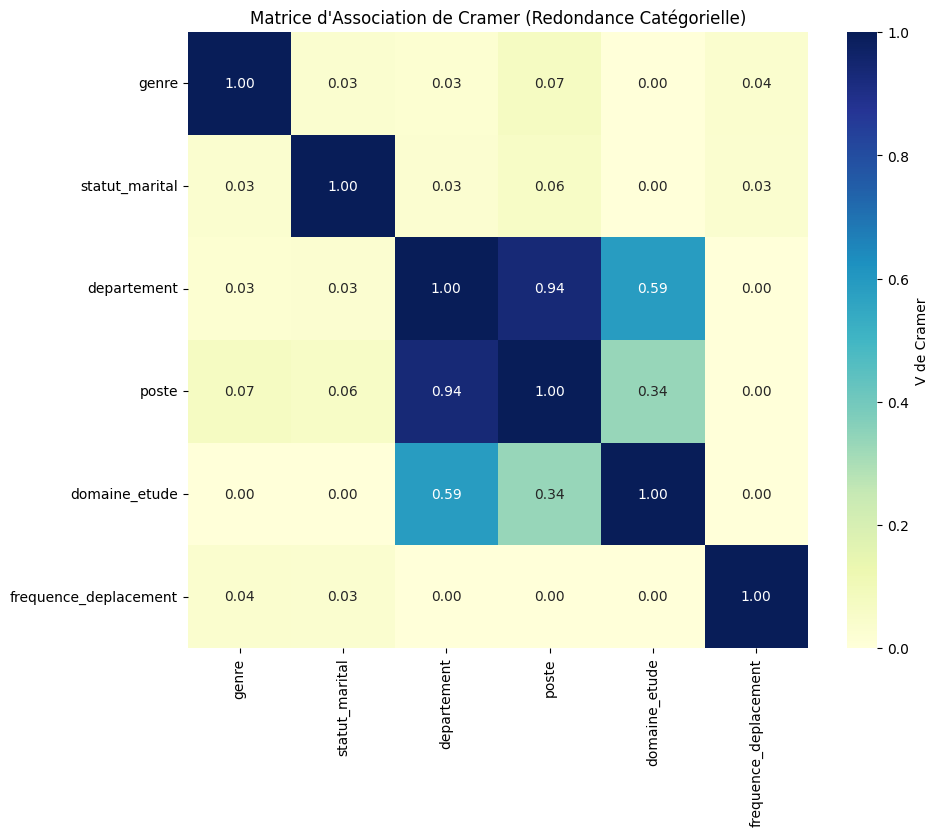


                   🧪 ANALYSE DE DÉPENDANCE (Test du Khi-Deux)                   
                         Cible : a_quitte_l_entreprise                          
-------------------------------------------------------------------------------------
  COLONNE                             | P-VALUE      | DÉPENDANCE      | ÉTAT
-------------------------------------------------------------------------------------
• genre                             | 2.9057e-01   | NON             | ⚪ Faible/Nulle
• statut_marital                    | 9.4555e-11   | OUI             | 🟢 Forte
• departement                       | 4.5256e-03   | OUI             | 🟡 Significative
• poste                             | 2.7525e-15   | OUI             | 🟢 Forte
• domaine_etude                     | 6.7740e-03   | OUI             | 🟡 Significative
• frequence_deplacement             | 5.6086e-06   | OUI             | 🟢 Forte
-------------------------------------------------------------------------------------
[('d

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Usamos un mapa de colores secuencial para resaltar la fuerza (0 a 1)
sns.heatmap(v_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': "V de Cramer"})
plt.title("Matrice d'Association de Cramer (Redondance Catégorielle)")
plt.show()

df_results = analyse_contingence_target(cleaner.df, cleaner.COLS_CATEGORICAL, FEATURE_TARGET_INITIAL)

redundantes = find_redundant_pairs(v_matrix, threshold=0.75) # Umbral sugerido por Bengio
print(redundantes)

### Candidates a Suppresion 👤

**El Veredicto: ¿Cuál borrar?**

**Borrar `departement` y conservar `poste`.**

Aquí tienes el razonamiento de nivel universitario para esta decisión:

1. **Poder Predictivo ():** En tu análisis anterior,
   * `poste` tenía una p-value de **$2.75 \times 10^{-15}$** frente a la target, mientras que
   * `departement` tenía **$4.52 \times 10^{-03}$**. `poste` tiene una señal mucho más fuerte y precisa hacia la meta.
3. **Granularidad:** `poste` es una variable más específica (un "Sales Executive" es más informativo que simplemente "Sales"). Al conservar el puesto, conservas implícitamente la información del departamento.
4. **Jerarquía de Información:** En este dataset, el puesto "envuelve" al departamento. Si sabes el puesto, casi siempre sabes el departamento, pero no al revés.



In [51]:
COLS_REDONDANTS.append('departement')
cleaner.COLS_REDONDANTS.append('departement')

### 🗑️ Suppression des Colonnes Redondants

In [52]:
cleaner.df, meta_dict_enrichi = cleaner.supprier_colonnes_REDONDANTS(df = cleaner.df,
    meta_dict      = meta_dict_enrichi, 
    cols_to_remove = cleaner.COLS_REDONDANTS, 
    reason="Categorical Correlation V de Cramer=0.94 avec 'poste'"
)


🗑️ Nettoyage de la redondance : 1 colonnes à traiter.
  • departement          | Statut : ❌ Supprimé du DataFrame


### Identifier Transformations Categorielles

#### get_categorical_encoding_blueprint

In [53]:
blueprint = cleaner.get_categorical_encoding_blueprint(cleaner.df, meta_dict_enrichi, max_o_ohe=12, max_binary=18)

🔍 ANALYSE ET SYNCHRONISATION DU BLUEPRINT
Colonne                      | Stratégie              | Aperçu Modalités
-------------------------------------------------------------------------------------
genre                        | ✅ OneHotEncoding       | F, M
statut_marital               | ✅ OneHotEncoding       | Célibataire, Divorcé(e), Marié(e)
poste                        | ✅ OneHotEncoding       | Assistant de Direction, Cadre Co...
domaine_etude                | ✅ OneHotEncoding       | Autre, Entrepreunariat, Infra & ...
frequence_deplacement        | ✅ OneHotEncoding       | Aucun, Frequent, Occasionnel
-------------------------------------------------------------------------------------
✅ Sync terminée. OHE: 5 | Binary: 0 | Target: 0


In [54]:
cleaner.show_dictionary_classified(meta_dict_enrichi)


--- 🗑️ COLUMNAS A SUPRIMIR (8) ---
  COLONNE                                       | ACTION/ENC           | NOTE / CONTENU
  ---------------------------------------------------------------------------------------
• a_quitte_l_entreprise                         | ❌ Suppresion         | VARIABLE CIBLE - Deja codifiqué dans la phase EDA
• id                                            | ❌ Suppresion         | Identifiant utilisé dans le merge
• id_employee                                   | ❌ Suppresion         | Identifiant technique sans valeur prédictive (df_sirh)
• code_sondage                                  | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (df_sondage)
• eval_number                                   | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (evals)
• nombre_employee_sous_responsabilite           | ❌ Suppresion         | Constant
• nombre_heures_travailless                     | ❌ Suppresion         | Constant
• aya

### 🗑️ Suppression du Target Original

In [55]:
if FEATURE_TARGET_INITIAL in cleaner.df.columns:
    cleaner.df = cleaner.df.drop(columns=[FEATURE_TARGET_INITIAL])
    print(f"🗑️ Columna FEATURE_TARGET_INITIAL eliminada de cleaner.df")

cleaner.df.info()

🗑️ Columna FEATURE_TARGET_INITIAL eliminada de cleaner.df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        1470 non-null   int64  
 1   genre                                      1470 non-null   object 
 2   revenu_mensuel                             1470 non-null   int64  
 3   statut_marital                             1470 non-null   object 
 4   poste                                      1470 non-null   object 
 5   nombre_experiences_precedentes             1470 non-null   int64  
 6   annee_experience_totale                    1470 non-null   int64  
 7   annees_dans_l_entreprise                   1470 non-null   int64  
 8   annees_dans_le_poste_actuel                1470 non-null   int64  
 9   satisfaction_employee_environnement   

## 🔸 STEP 3. Codification Numerique

### Identification des Numeriques Redondants

####  Analyse Multivariée et Corrélations

**Matrice de Corrélation (Heatmap des variables numériques pertinentes)**


**1. La Nature des Données (Numérique vs Catégorique)**

La matrice de corrélation classique (Pearson) est strictement réservée aux **variables numériques**.

* **Ce qui peut être inclus :** `Âge`, `Revenu_Mensuel`, `Années_Expérience`.
* **Ce qui NE doit PAS être inclus (directement) :** `Département`, `Poste`, `Genre`.
* **Le piège :** Si tu as encodé ton `Genre` en (0, 1), tu peux techniquement calculer une corrélation, mais pour des variables à plus de deux catégories (ex: 5 départements), le chiffre obtenu n'a aucune valeur mathématique.

**2. Pearson vs Spearman : Choisir son arme**

Le point de vigilance de ton énoncé mentionne ces deux méthodes. Voici la différence cruciale pour ton projet TechNova :

* **Pearson (Linéaire) :** Mesure la relation en ligne droite.
* *Exemple :* Plus tu travailles d'heures (X), plus ton salaire augmente (Y) de façon constante.
* *Sensibilité :* Très sensible aux **outliers** (valeurs atypiques).


* **Spearman (Rang) :** Mesure si les variables évoluent dans le même sens, même si ce n'est pas linéaire.
* *Exemple :* Les scores de `Satisfaction`. Passer de "Satisfait" (3) à "Très Satisfait" (4) n'est pas forcément le même "saut" que de 1 à 2, mais l'ordre compte.
* *Utilité :* Indispensable pour tes variables de type `satisfaction_employee` et `niveau_education`.



**3. Les Variables "Binaires" (Dichotomiques)**

Pour ta variable cible `a_quitte_l_entreprise` (0 ou 1) :

* Tu peux utiliser la corrélation de Pearson avec des variables numériques (on appelle cela techniquement la corrélation *point-bisériale*). Cela te donne une première idée de quelles variables (comme le salaire) influencent le départ.

**4. Attention à la Colinéarité (Multicolinéarité)**

L'objectif de la matrice dans l'étape 2 est d'**éliminer les fortes corrélations**.

* Si `Années_dans_l_entreprise` et `Années_dans_le_poste_actuel` ont une corrélation de **0.95**, elles racontent la même histoire.
* **Conseil d'expert (Dario Amodei) :** Garder les deux peut perturber certains modèles (comme la régression logistique). Il faut souvent en supprimer une.

---

**Synthèse pour ton Notebook**

| Type de Feature | Méthode conseillée | Pourquoi ? |
| --- | --- | --- |
| **Numérique Continue** (Salaire, Âge) | **Pearson** | Pour les relations linéaires simples. |
| **Numérique Ordinale** (Satisfaction, Éducation) | **Spearman** | Pour respecter l'ordre sans supposer une linéarité. |


#### analyze_correlations

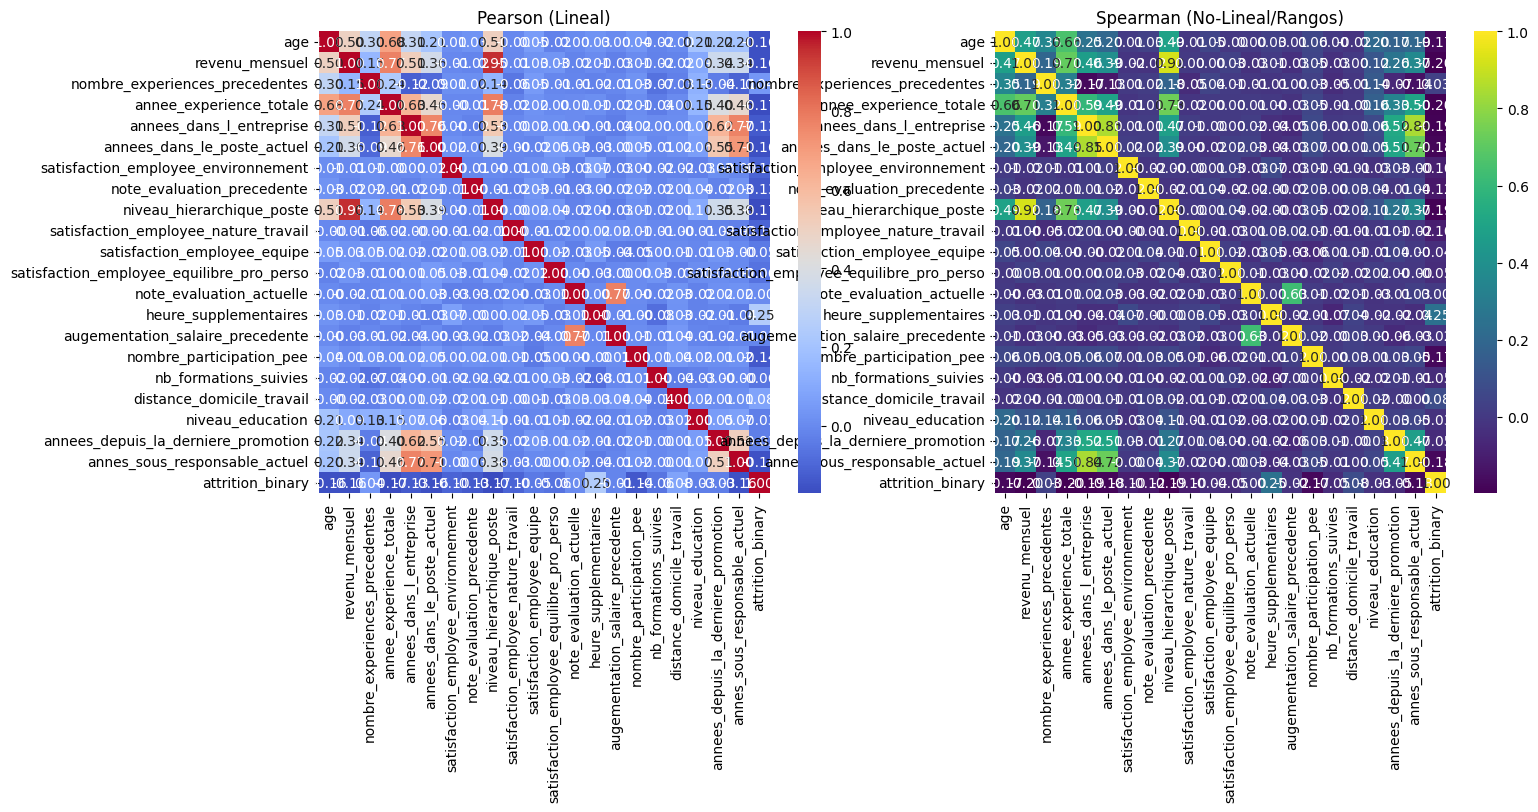

In [56]:
def analyze_correlations(df):
    # Solo variables numéricas
    df_num = df.select_dtypes(include=['number'])
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pearson
    sns.heatmap(df_num.corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm', ax=ax[0])
    ax[0].set_title('Pearson (Lineal)')
    
    # Spearman
    sns.heatmap(df_num.corr(method='spearman'), annot=True, fmt=".2f", cmap='viridis', ax=ax[1])
    ax[1].set_title('Spearman (No-Lineal/Rangos)')
    
    plt.show()

# Ejecutar análisis
analyze_correlations(cleaner.df)

#### filtrer_features_pertinentes

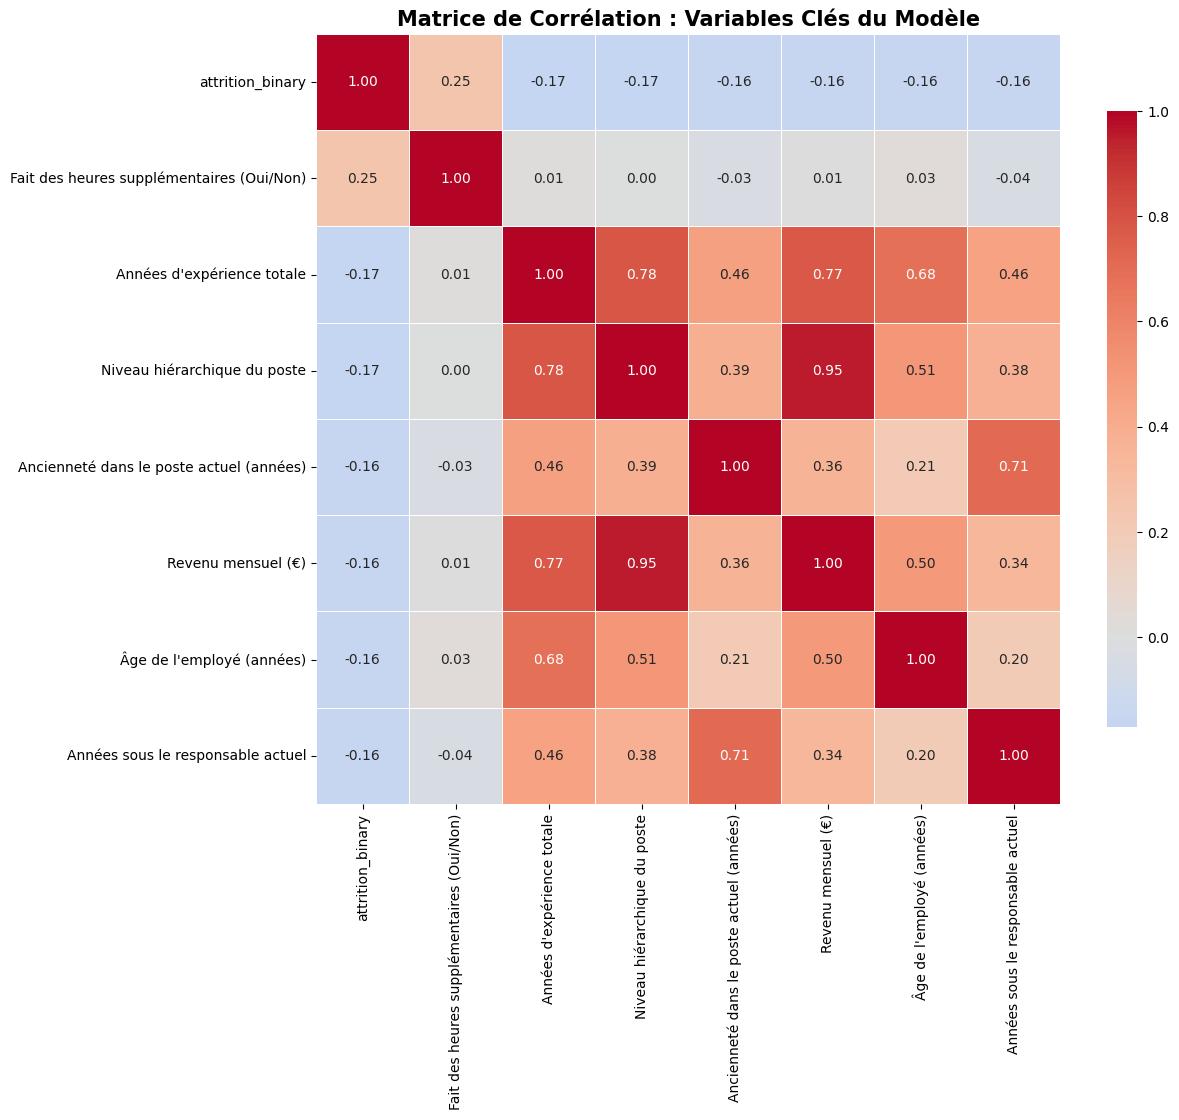

In [57]:
# 1. Sélection automatique des variables corrélées à plus de 40% (0.4) avec la cible
# Cela nous permet de voir ce qui influence réellement les émissions.
top_features = cleaner.filtrer_features_pertinentes(cleaner.df, target=FEATURE_TARGET, threshold=0.15)

# 2. Affichage de la Heatmap
cleaner.plot_correlation_heatmap(cleaner.df, top_features, meta_dict)

#### rapport_redondance

In [58]:

# 1. Ejecutar la detección de redundancia con el umbral de 0.90
lista_redondancias = cleaner.rapport_redondance(cleaner.df, threshold=THRESHOLD_NUMERICAL_REDONDANCE)

print(f"🚩 IDENTIFICACIÓN DE REDUNDANCIAS (Correlación > {THRESHOLD_NUMERICAL_REDONDANCE}):")
print("-" * 60)

if not lista_redondancias:
    print("✅ No se detectaron variables redundantes.")
else:
    for item in lista_redondancias:
        v1   = item['var1'] # Nombre técnico original
        v2   = item['var2'] # Nombre técnico original
        corr = item['correlation']
        
        # Obtenemos el nombre descriptivo del diccionario, o el original si no existe
        n1   = meta_dict.get(v1, v1)
        n2   = meta_dict.get(v2, v2)
        
        # Formato: Nombre Amigable (Nombre_Técnico)
        print(f"⚠️ {n1} ({v1})  <--->  {n2} ({v2})")
        print(f"   Indice de corrélation : {corr:.4f}")
        print("-" * 60)

# 2. Decisión técnica
cols_a_eliminar = list(set([item['var2'] for item in lista_redondancias]))
print(f"\n💡 Sugerencia técnica: Eliminar {len(cols_a_eliminar)} variables para evitar multicolinealidad.")
print(f"Variables sugeridas (nombres técnicos): {cols_a_eliminar}")

🚩 IDENTIFICACIÓN DE REDUNDANCIAS (Correlación > 0.9):
------------------------------------------------------------
⚠️ Revenu mensuel (€) (revenu_mensuel)  <--->  Niveau hiérarchique du poste (niveau_hierarchique_poste)
   Indice de corrélation : 0.9503
------------------------------------------------------------

💡 Sugerencia técnica: Eliminar 1 variables para evitar multicolinealidad.
Variables sugeridas (nombres técnicos): ['niveau_hierarchique_poste']


### Candidates a Suppresion 👤

In [59]:
COLS_REDONDANTS.append('niveau_hierarchique_poste')
cleaner.COLS_REDONDANTS.append('niveau_hierarchique_poste')

### 🗑️ Suppression des Colonnes Redondants

In [60]:
cleaner.df, meta_dict_enrichi = cleaner.supprier_colonnes_REDONDANTS(df = cleaner.df,
    meta_dict      = meta_dict_enrichi, 
    cols_to_remove = cleaner.COLS_REDONDANTS, 
    reason=f"Numerical Correlation Pearson (Lineal) > {THRESHOLD_NUMERICAL_REDONDANCE} avec 'poste' {FEATURE_TARGET}"
)


🗑️ Nettoyage de la redondance : 2 colonnes à traiter.
  ℹ️ Info : 'departement' est déjà marqué pour suppression. Passage...
  • niveau_hierarchique_poste | Statut : ❌ Supprimé du DataFrame


### Identifier Transformations Numeriques

In [61]:
# Ejecución de la síntesis estadística
stats_desc, cols_log, cols_robust, cols_std, echelles_ext = cleaner.analyser_statistiques_globales(cleaner.df)

# Mostrar el resumen estadístico con las nuevas columnas calculadas
print("\n📋 RÉSUMÉ STATISTIQUE ÉTENDU :")
print(stats_desc.columns.tolist())
print(stats_desc[['mean', 'std', 'min', 'max', 'Skewness', 'CV', '25%', '50%', '75%', 'Nature', 'Action_Recommandee']].head(20).to_markdown())


DIAGNOSTIC GLOBAL ET CLASSIFICATION DES COLONNES
 Variables analysées : 21    | Nuls critiques (>10%): 0
 Variables Log (Asymétriques)..: 4
 Variables Robust (Outliers)..: 0
 Variables Standard (RAS).....: 17
 Alertes......................: 13
--------------------------------------------------------------------------------

📋 RÉSUMÉ STATISTIQUE ÉTENDU :
['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Missing_Count', 'Missing_Pct', 'Range', 'Skewness', 'CV', 'Uniques', 'Nature', 'Action_Recommandee']
|                                      |        mean |          std |     min |      max |   Skewness |       CV |     25% |     50% |     75% | Nature            | Action_Recommandee                       |
|:-------------------------------------|------------:|-------------:|--------:|---------:|-----------:|---------:|--------:|--------:|--------:|:------------------|:-----------------------------------------|
| annees_depuis_la_derniere_promotion  |    2.18776  |    3.22243

#### get_numerical_encoding_blueprint

In [62]:
# 2. Empaquetamos para el actualizador (Mapping Expert)
mapping_expert = {
    'num_log'     : cols_log,
    'num_robust'  : cols_robust,
    'num_std'     : cols_std
}

# 3. Llamar al blueprint (esto actualiza tu meta_dict y las listas de la clase)
numeric_blueprint = cleaner.get_numerical_encoding_blueprint(cleaner.df, meta_dict_enrichi, mapping_expert)

# 4. Ahora tu info para el pipeline está garantizada
info_final = {
    'num_log': cleaner.COLS_TO_LOG,
    'num_robust': cleaner.COLS_TO_ROBUST,
    'num_std': cleaner.COLS_STANDARD,
    'cat_ohe': cleaner.COLS_ONE_HOT_ENCODING, # Asumiendo que ya corriste el otro blueprint
    'indic_nan': cleaner.df.columns[cleaner.df.isnull().any()].tolist()
}


🔍 ANALYSE ET SYNCHRONISATION DU BLUEPRINT NUMÉRIQUE
Colonne                                  | Stratégie              | Métriques (Skew/CV)
-------------------------------------------------------------------------------------
note_evaluation_actuelle                 | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
satisfaction_employee_equipe             | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
annees_dans_l_entreprise                 | 🚀 Log Transform        | Skew: 1.76
attrition_binary                         | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
heure_supplementaires                    | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
satisfaction_employee_environnement      | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
distance_domicile_travail                | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
annes_sous_responsable_actuel            | 🔔 Standardize (RAS)    | Normal/Binaire/Orphan
satisfaction_employee_equilibre_pro_perso | 🔔 Standardize (RAS) 

In [63]:
cleaner.show_dictionary_classified(meta_dict_enrichi)


--- 🗑️ COLUMNAS A SUPRIMIR (8) ---
  COLONNE                                       | ACTION/ENC           | NOTE / CONTENU
  ---------------------------------------------------------------------------------------
• a_quitte_l_entreprise                         | ❌ Suppresion         | VARIABLE CIBLE - Deja codifiqué dans la phase EDA
• id                                            | ❌ Suppresion         | Identifiant utilisé dans le merge
• id_employee                                   | ❌ Suppresion         | Identifiant technique sans valeur prédictive (df_sirh)
• code_sondage                                  | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (df_sondage)
• eval_number                                   | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (evals)
• nombre_employee_sous_responsabilite           | ❌ Suppresion         | Constant
• nombre_heures_travailless                     | ❌ Suppresion         | Constant
• aya

✴️ ✴️ ✴️ ✴️


**1. Log Transform (Transformation Logarithmique)**

Le but n'est pas seulement de changer l'échelle, mais de **changer la forme** de la distribution.

* **Quand l'utiliser :** Lorsque tu as une **asymétrie positive forte (Skewness > 1)**. Dans ton dataset, c'est le cas pour `revenu_mensuel` ou `annees_dans_l_entreprise`.
* **L'effet mathématique :** Elle "compresse" les valeurs très élevées (les hauts salaires) et "étire" les petites valeurs.
* **Pourquoi ?** Elle transforme une distribution "à longue traîne" en une distribution qui ressemble à une **cloche de Gauss** (normale). Cela aide les modèles linéaires à ne pas être biaisés par les valeurs extrêmes.

**2. Scaling (Mise à l'échelle / Min-Max Scaling)**

Ici, on ne change pas la forme de la distribution, on la **récompresse** simplement dans un intervalle fixe.

* **Quand l'utiliser :** Lorsque tu as des variables avec des unités très différentes (ex: `age` entre 18-60 et `distance_domicile` entre 1-30).
* **L'effet mathématique :** La formule  ramène tout entre **0 et 1**.
* **Pourquoi ?** Pour que le modèle ne croie pas que le Salaire est "plus important" que l'Âge simplement parce que ses chiffres sont plus grands.

**3. RAS / Standardize (Standardisation)**

C'est la méthode "par défaut" (d'où le **RAS** : *Rien À Signaler*). Elle repose sur la moyenne et l'écart-type.

* **Quand l'utiliser :** Pour les variables qui ont déjà une forme de cloche (Skewness proche de 0) mais qui ont besoin d'être centrées.
* **L'effet mathématique :** On transforme la variable pour que sa **moyenne soit 0** et son **écart-type soit 1**.
* **Pourquoi ?** C'est la méthode préférée pour les algorithmes comme les SVM ou les Réseaux de Neurones. On ne perd pas d'information, on déplace juste les données pour qu'elles soient centrées sur l'origine.


**🎓 Synthèse pour ton Rapport TechNova**

| Technique | Objectif Principal | Impact sur la Forme | Variable Type |
| --- | --- | --- | --- |
| **Log Transform** | Réduire l'asymétrie | **Change la forme** | `revenu_mensuel` |
| **Scaling (Min-Max)** | Borner les valeurs | Garde la forme | `distance_domicile` |
| **Standardize** | Centrer les données | Garde la forme | `age` |


✴️ ✴️ ✴️ ✴️

**1. Pour le **Log Transform** (Réduction de l'asymétrie)**

Comme Scikit-Learn ne possède pas de classe "Log" dédiée, on utilise un outil flexible :

* **`FunctionTransformer`** (dans `sklearn.preprocessing`) : C'est la méthode la plus propre. Elle permet d'appliquer la fonction mathématique de votre choix (souvent `np.log1p` pour gérer les zéros).
* *Exemple :* `FunctionTransformer(np.log1p)`


* **`PowerTransformer`** (dans `sklearn.preprocessing`) : Si vous voulez que l'algorithme trouve lui-même la meilleure transformation pour rendre les données "normales" (via la méthode *Yeo-Johnson*).

---

**2. Pour le **Scaling / Min-Max** (Compression d'échelle)**

C'est la méthode pour ramener les données dans un intervalle strict :

* **`MinMaxScaler`** (dans `sklearn.preprocessing`) : Transforme les données pour qu'elles tiennent entre **0 et 1**.
* *Attention :* Très sensible aux valeurs aberrantes (outliers), car elles compressent trop le reste des données.



---

**3. Pour le **Standardize / RAS** (Normalisation)**

C'est la méthode de référence pour les modèles linéaires et les réseaux de neurones :

* **`StandardScaler`** (dans `sklearn.preprocessing`) : C'est le standard. Il transforme les données pour avoir une **moyenne de 0** et un **écart-type de 1**.
* **`RobustScaler`** (dans `sklearn.preprocessing`) : Si votre analyse a détecté un **CV élevé** ou beaucoup d'outliers, utilisez celui-ci. Il utilise la médiane et les quartiles, ce qui le rend insensible aux valeurs extrêmes.
*

---

**4. Le Chef d'Orchestre : **ColumnTransformer**

Pour appliquer toutes ces classes en une seule fois sur vos différentes colonnes, on utilise :

* **`ColumnTransformer`** (dans `sklearn.compose`) : C'est l'outil qui permet de dire : *"Applique le Log à ces 5 colonnes, le StandardScaler à ces 10 autres, et le OneHotEncoder aux variables catégoriques"*.
*

---

**🎓 Résumé pour TechNova**

| Opération technique | Classe Scikit-Learn | Type de variable cible |
| --- | --- | --- |
| **Log Transform** | `FunctionTransformer(np.log1p)` | `revenu_mensuel` (Asymétrique) |
| **Standardisation** | `StandardScaler()` | `age` (Distribution normale) |
| **Scaling Robuste** | `RobustScaler()` | `annees_dans_entreprise` (Outliers) |
| **Encodage** | `OneHotEncoder()` | `departement` (Nominale) |


### ViIsualisation

#### Plot variables asymétriques

📊 Analyse visuelle des variables asymétriques (Candidats au Log)


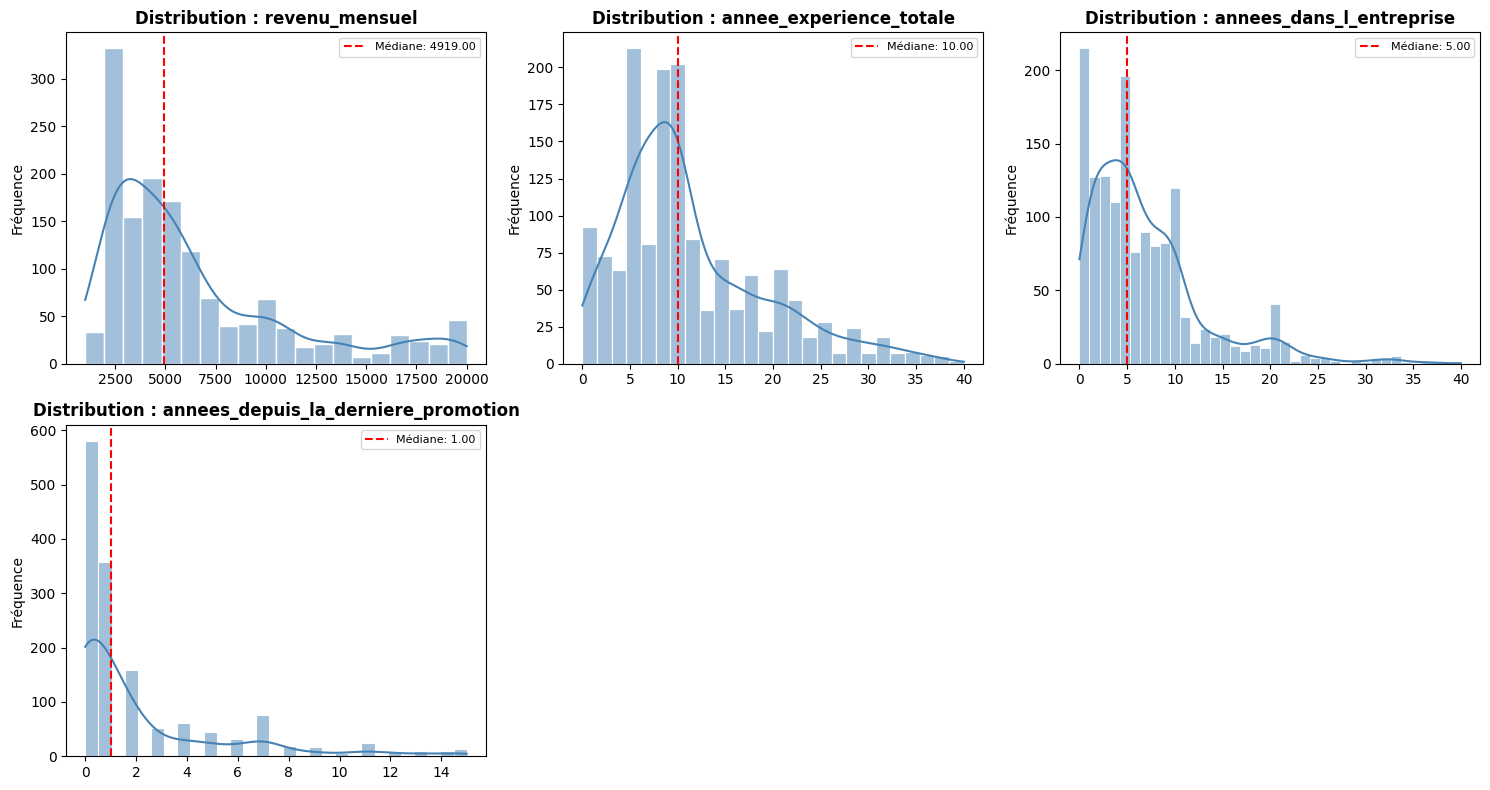

In [64]:
# 1. Visualisons uniquement les variables asymétriques (celles identifiées avant)
print("📊 Analyse visuelle des variables asymétriques (Candidats au Log)")
fig_dist = cleaner.plot_distributions_grille(cleaner.df, columns=cols_log)

if fig_dist:
    plt.show()

In [65]:
# Generar el diagnóstico experto
df_expert = cleaner.interpreter_proprietes_vars(cleaner.df)

# Mostrar el resultado profesional
print(df_expert.to_markdown(index=False))


ÉTAPE 3.5 : INTERPRÉTATION AUTOMATIQUE DU DATASET
| Variable                                  | Asymétrie                 | Type_Queues                         | Outliers_IQR     | Action_Data          |
|:------------------------------------------|:--------------------------|:------------------------------------|:-----------------|:---------------------|
| age                                       | Symétrique (Normale)      | Queues normales                     | Aucun            | Standardize          |
| revenu_mensuel                            | Asymétrie Positive (1.4)  | Queues lourdes (Outliers probables) | Critique (7.8%)  | Log + Robust Scaling |
| nombre_experiences_precedentes            | Asymétrie Positive (1.0)  | Queues normales                     | Modérée (3.5%)   | Standardize          |
| annee_experience_totale                   | Asymétrie Positive (1.1)  | Queues normales                     | Modérée (4.3%)   | Standardize          |
| annees_dans_l_entrepris

#### Pairplot Estratégico

Hacer un pairplot de 22 variables generaría una imagen ilegible de 484 gráficos. 

Debemos ser selectivos. Vamos a cruzar las variables con más asimetría (cols_asym) contra el age y el revenu_mensuel.

Generando Pairplot para: ['note_evaluation_actuelle', 'revenu_mensuel', 'annees_dans_l_entreprise', 'annees_depuis_la_derniere_promotion', 'attrition_binary', 'age']


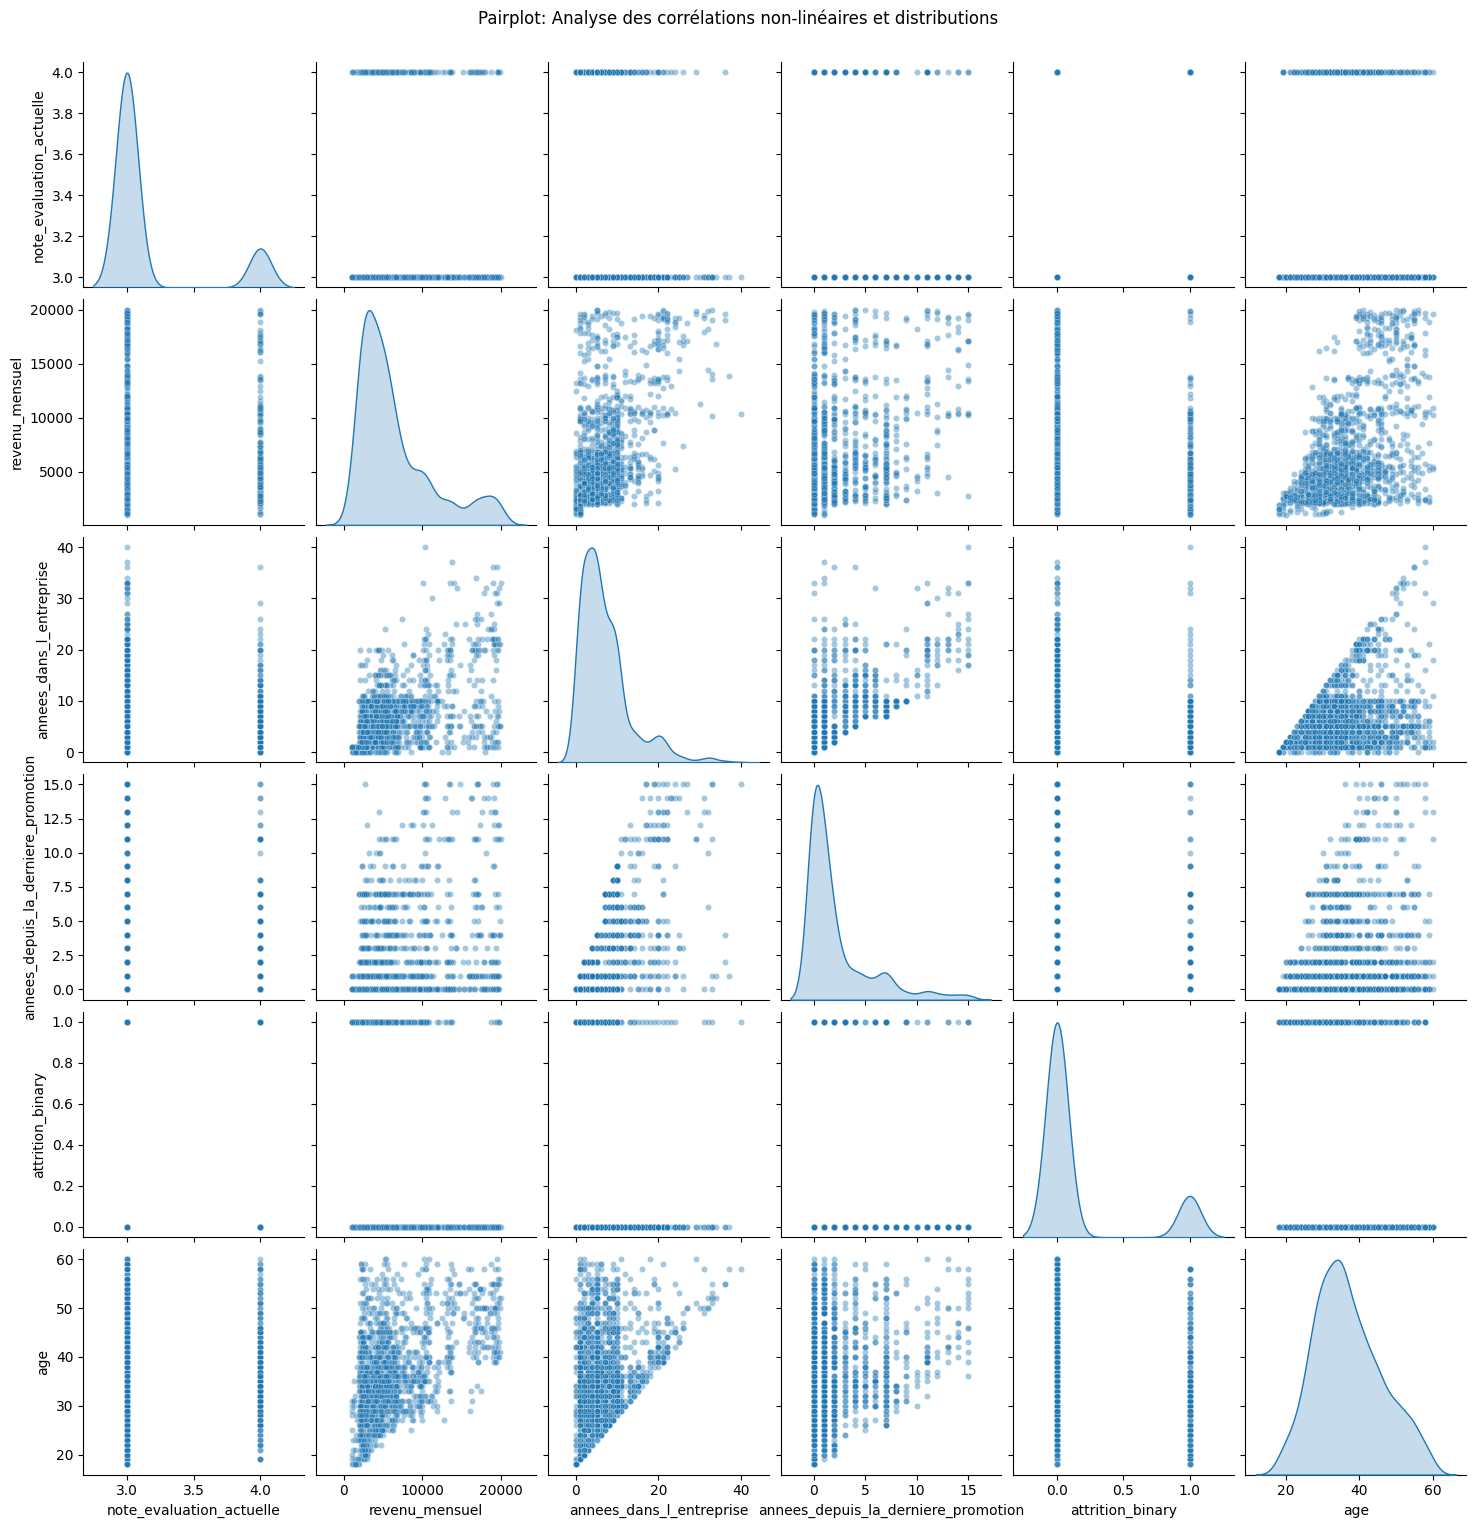

In [66]:
# Seleccionamos las "Top Offenders" de tu diagnóstico por asimetría
top_skewed = stats_desc.sort_values('Skewness', ascending=False).index[:5].tolist()

# Añadimos una variable de control como el 'age'
cols_to_plot = list(set(top_skewed + ['age']))

print(f"Generando Pairplot para: {cols_to_plot}")

# Creamos el Pairplot
# 'diag_kind="kde"' nos muestra la distribución real de cada variable
sns.pairplot(cleaner.df[cols_to_plot], diag_kind='kde', plot_kws={'alpha': 0.4, 's': 20})
plt.suptitle("Pairplot: Analyse des corrélations non-linéaires et distributions", y=1.02)
plt.show()

## RAPPORT de Transformations

In [67]:
cleaner.show_dictionary_classified(meta_dict_enrichi)
cleaner.display_feature_summary()


--- 🗑️ COLUMNAS A SUPRIMIR (8) ---
  COLONNE                                       | ACTION/ENC           | NOTE / CONTENU
  ---------------------------------------------------------------------------------------
• a_quitte_l_entreprise                         | ❌ Suppresion         | VARIABLE CIBLE - Deja codifiqué dans la phase EDA
• id                                            | ❌ Suppresion         | Identifiant utilisé dans le merge
• id_employee                                   | ❌ Suppresion         | Identifiant technique sans valeur prédictive (df_sirh)
• code_sondage                                  | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (df_sondage)
• eval_number                                   | ❌ Suppresion         | Identifiant de sondage sans valeur prédictive (evals)
• nombre_employee_sous_responsabilite           | ❌ Suppresion         | Constant
• nombre_heures_travailless                     | ❌ Suppresion         | Constant
• aya

35

## ✂️ Step 4. SPLIT X Y 

In [68]:
cleaner.FEATURES_TO_REMOVE  =  FEATURES_TO_REMOVE  = COLS_IDENTIFIANTS + COLS_CONSTANT + COLS_MISSING_EXCESIF + COLS_REDONDANTS

# Appel de la fonction
X, y = cleaner.pipeline_preparation_initiale(
    df           = cleaner.df, 
    target       = FEATURE_TARGET, 
    cols_to_drop = FEATURES_TO_REMOVE
)


--- Nettoyage des colonnes ---
ℹ️ Colonne ignorée (déjà absente) : id
ℹ️ Colonne ignorée (déjà absente) : id_employee
ℹ️ Colonne ignorée (déjà absente) : eval_number
ℹ️ Colonne ignorée (déjà absente) : code_sondage
ℹ️ Colonne ignorée (déjà absente) : nombre_heures_travailless
ℹ️ Colonne ignorée (déjà absente) : nombre_employee_sous_responsabilite
ℹ️ Colonne ignorée (déjà absente) : ayant_enfants
ℹ️ Colonne ignorée (déjà absente) : departement
ℹ️ Colonne ignorée (déjà absente) : niveau_hierarchique_poste
------------------------------------------------------------
🎯 CIBLE (y)      : attrition_binary
🧬 FEATURES (X)   : ['age', 'genre', 'revenu_mensuel', 'statut_marital', 'poste', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_

## 🔗 Step 5. PIPELINE pour Feature Engineering Initial 

### ⬇️ LOAD Transformation Functions

In [69]:
# ------------------------------------------------------------------------------
def log_transform(df_x):
    """Applique log(1+x) avec gestion des valeurs négatives."""
    df_x             = df_x.copy()
    for col in df_x.columns:
        if df_x[col].min() < 0:
            offset   = abs(df_x[col].min()) + 1
            df_x[col] = np.log1p(df_x[col] + offset)
        else:
            df_x[col] = np.log1p(df_x[col])
    return df_x

# ------------------------------------------------------------------------------

def winsorize_transform(df_x, lower=0.01, upper=0.99):
    """Limite les valeurs extrêmes aux percentiles définis."""
    df_x             = df_x.copy()
    for col in df_x.columns:
        q_low        = df_x[col].quantile(lower)
        q_high       = df_x[col].quantile(upper)
        df_x[col]    = df_x[col].clip(lower=q_low, upper=q_high)
    return df_x

# On crée des fonctions simples qui appellent les originales avec les bons paramètres
# Cela remplace les lambdas qui bloquent le joblib.dump
def wrapper_winsorize(df_x):
    return winsorize_transform(df_x, lower=0.01, upper=0.99)

# ------------------------------------------------------------------------------

def create_missing_indicators(df_x, cols_to_flag):
    """Crée des drapeaux binaires pour les valeurs manquantes importantes."""
    df_x             = df_x.copy()
    for col in cols_to_flag:
        if col in df_x.columns:
            df_x[f'{col}_Nan'] = df_x[col].isna().astype(int)
    return df_x

# On crée des fonctions simples qui appellent les originales avec les bons paramètres
# Cela remplace les lambdas qui bloquent le joblib.dump
def wrapper_missing_indicators(df_x, cols_to_flag):
    return create_missing_indicators(df_x, cols_to_flag)

### ⬇️ LOAD Create features

In [70]:
def create_features(df_x):
    """Génère de nouvelles variables métier (Feature Engineering)."""
    df_x             = df_x.copy()

    # TODO plus tard

    return df_x

### ⬇️ LOAD Funtion Create Pre-Pipeline

In [71]:
def build_preprocessing_pipeline(df_x, v_y=None, info=None):
    """
    Assemble les briques de transformation de manière dynamique.
    
    Paramètres:
    -----------
    df_x : DataFrame d'entrée (Features)
    v_y  : Series cible (nécessaire pour le TargetEncoder)
    info : Dictionnaire généré par identifier_colonnes contenant la répartition des listes.
    """
    
    # Sécurité : Si info n'est pas fourni, on tente de le générer (mais il vaut mieux le passer)
    if info is None:
        # On suppose ici qu'une version simplifiée existe ou on lève une erreur
        raise ValueError("Le paramètre 'info' (mapping des colonnes) est obligatoire.")

    # --- 1.1 Sous-pipeline : ASYMÉTRIE CRITIQUE (Log + Winsor + Scaling) ---
    pipe_num_log = Pipeline(steps=[
        ('log',     FunctionTransformer(log_transform        , validate=False)),
        ('winsor',  FunctionTransformer(winsorize_transform  , validate=False, kw_args={'lower': 0.01, 'upper': 0.99})),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler())
    ])

    # --- 1.2 Sous-pipeline : ROBUSTE (Outliers, CV > 2) ---
    pipe_num_robust = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  RobustScaler()) 
    ])

    # --- 1.3 Sous-pipeline : STANDARD (RAS) ---
    pipe_num_std = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler())
    ])

    # --- 1.4 Sous-pipeline : CATÉGORIEL (One-Hot) ---
    pipe_cat_ohe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant'    , fill_value='NULL')),
        ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # --------------------------------------------------------------------------
    # 2. CONSTRUCTION DU DISPATCH
    # --------------------------------------------------------------------------
    dispatch = []
    
    # On ajoute les branches uniquement si les listes ne sont pas vides
    # Cela évite les erreurs de Scikit-Learn sur des listes vides
    if info['num_log']:    dispatch.append(('n_log',    pipe_num_log,    info['num_log']))
    if info['num_robust']: dispatch.append(('n_robust', pipe_num_robust, info['num_robust']))
    if info['num_std']:    dispatch.append(('n_std',    pipe_num_std,    info['num_std']))
    if info['cat_ohe']:    dispatch.append(('c_ohe',    pipe_cat_ohe,    info['cat_ohe']))

    if v_y is not None and info.get('cat_target'):
        pipe_target = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='NULL')),
            ('target',  TargetEncoder(smoothing=10, min_samples_leaf=20))
        ])
        dispatch.append(('c_target', pipe_target, info['cat_target']))

    preprocessor = ColumnTransformer(transformers=dispatch, remainder='drop')

    # --------------------------------------------------------------------------
    # 3. PIPELINE GLOBAL
    # --------------------------------------------------------------------------
    return Pipeline(steps=[
        ('nan_flags', FunctionTransformer(create_missing_indicators, validate=False, kw_args={'cols_to_flag': info['indic_nan']})),
        ('feat_eng' , FunctionTransformer(create_features, validate=False)),
        ('preproc'  , preprocessor)
    ])

### 5.1 Pipeline Preparation Initiale. Clean and Remove 

In [72]:
# 1. Limpieza estructural (Tu primer método)
# Retorna X (Pandas DataFrame con nulos) y y (Series)
X_raw, y = cleaner.pipeline_preparation_initiale(cleaner.df, target=FEATURE_TARGET, cols_to_drop=cleaner.FEATURES_TO_REMOVE)
X_raw


--- Nettoyage des colonnes ---
ℹ️ Colonne ignorée (déjà absente) : id
ℹ️ Colonne ignorée (déjà absente) : id_employee
ℹ️ Colonne ignorée (déjà absente) : eval_number
ℹ️ Colonne ignorée (déjà absente) : code_sondage
ℹ️ Colonne ignorée (déjà absente) : nombre_heures_travailless
ℹ️ Colonne ignorée (déjà absente) : nombre_employee_sous_responsabilite
ℹ️ Colonne ignorée (déjà absente) : ayant_enfants
ℹ️ Colonne ignorée (déjà absente) : departement
ℹ️ Colonne ignorée (déjà absente) : niveau_hierarchique_poste
------------------------------------------------------------
🎯 CIBLE (y)      : attrition_binary
🧬 FEATURES (X)   : ['age', 'genre', 'revenu_mensuel', 'statut_marital', 'poste', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_

,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,...,heure_supplementaires,augementation_salaire_precedente,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,41,F,5993,Célibataire,Cadre Commercial,8,8,6,4,2,...,1,0.11,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,49,M,5130,Marié(e),Assistant de Direction,1,10,10,7,3,...,0,0.23,1,3,8,1,Infra & Cloud,Frequent,1,7
2,37,M,2090,Célibataire,Consultant,6,7,0,0,4,...,1,0.15,0,3,2,2,Autre,Occasionnel,0,0
3,33,F,2909,Marié(e),Assistant de Direction,1,8,8,7,4,...,1,0.11,0,3,3,4,Infra & Cloud,Frequent,3,0
4,27,M,3468,Marié(e),Consultant,9,6,2,2,1,...,0,0.12,1,3,2,1,Transformation Digitale,Occasionnel,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,M,2571,Marié(e),Consultant,4,17,5,2,3,...,0,0.17,1,3,23,2,Transformation Digitale,Frequent,0,3
1466,39,M,9991,Marié(e),Manager,4,9,7,7,4,...,0,0.15,1,5,6,1,Transformation Digitale,Occasionnel,1,7
1467,27,M,6142,Marié(e),Tech Lead,1,6,6,2,2,...,1,0.20,1,0,4,3,Infra & Cloud,Occasionnel,0,3
1468,49,M,5390,Marié(e),Cadre Commercial,2,17,9,6,4,...,0,0.14,0,3,2,3,Transformation Digitale,Frequent,0,8


In [73]:
# 1. Obtenemos las columnas reales que sobrevivieron en X_raw
columnas_vivas = set(X_raw.columns)

info_final = {
    'num_log':    [c for c in cleaner.COLS_TO_LOG    if c in columnas_vivas],
    'num_robust': [c for c in cleaner.COLS_TO_ROBUST if c in columnas_vivas],
    'num_std':    [c for c in cleaner.COLS_STANDARD  if c in columnas_vivas],
    'cat_ohe':    [c for c in cleaner.COLS_ONE_HOT_ENCODING if c in columnas_vivas],
    'cat_target': [c for c in cleaner.COLS_TARGET_ADVANCED_ENCODING if c in columnas_vivas],
    'indic_nan':  [c for c in X_raw.columns if X_raw[c].isnull().any()]
}

### 5.2 Create Pre-Pipeline

In [74]:
# 3. Construir el Pipeline Global
preprocessing_pipe = build_preprocessing_pipeline(X_raw, v_y=y, info=info_final)

### 5.3 Passage à la Matrice de Design (fit_transform)

Explication générale divisée en trois concepts clés :

**1. Le "Contrat" de Sortie (`set_output`)**

Par défaut, Scikit-Learn est un moteur mathématique qui renvoie des tableaux NumPy (de simples grilles de chiffres sans noms).

* En activant `transform="pandas"`, vous forcez l'outil à **conserver la structure**.
* Cela signifie que chaque colonne transformée garde un nom explicite (ex: `n_std__age`). C'est ce qui garantit la **traçabilité** : vous savez exactement ce qui est arrivé à chaque donnée.

**2. L'Exécution du Plan (`fit_transform`)**

C'est le moment où "l'usine" se met en marche. Cette commande réalise deux opérations en une :

* **`fit` (L'Apprentissage) :** Le pipeline calcule les paramètres statistiques sur vos données `X_raw` (la moyenne pour normaliser, les fréquences pour l'encodage, etc.).
* **`transform` (La Mutation) :** Il applique ces calculs pour convertir vos données brutes en chiffres optimisés.

**3. La Création de la "Matrice de Design"**

Le résultat, `X_final_df`, est ce qu'on appelle en statistiques une **Matrice de Design**. C'est un objet mathématique pur qui possède trois propriétés fondamentales :

1. **Homogénéité :** Il n'y a plus de texte, seulement des nombres (`float64`).
2. **Complétude :** Il n'y a plus de valeurs manquantes (les trous ont été bouchés par les *imputers*).
3. **Comparabilité :** Toutes les variables sont sur une échelle similaire (grâce au *scaling*), ce qui empêche une variable avec de gros chiffres d'écraser les autres.


In [75]:
preprocessing_pipe.set_output(transform="pandas")
X_final_df = preprocessing_pipe.fit_transform(X_raw, y)
X_final_df

,n_log__revenu_mensuel,n_log__annee_experience_totale,n_log__annees_dans_l_entreprise,n_log__annees_depuis_la_derniere_promotion,n_std__age,n_std__nombre_experiences_precedentes,n_std__annees_dans_le_poste_actuel,n_std__satisfaction_employee_environnement,n_std__note_evaluation_precedente,n_std__satisfaction_employee_nature_travail,...,c_ohe__poste_Tech Lead,c_ohe__domaine_etude_Autre,c_ohe__domaine_etude_Entrepreunariat,c_ohe__domaine_etude_Infra & Cloud,c_ohe__domaine_etude_Marketing,c_ohe__domaine_etude_Ressources Humaines,c_ohe__domaine_etude_Transformation Digitale,c_ohe__frequence_deplacement_Aucun,c_ohe__frequence_deplacement_Frequent,c_ohe__frequence_deplacement_Occasionnel
0,0.218262,-0.148970,0.178857,-0.974295,0.446350,2.125136,-0.063296,-0.660531,0.379672,1.153254,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.017266,0.144921,0.777704,-0.116765,1.322365,-0.678049,0.764998,0.254625,-1.026167,-0.660853,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.377263,-0.321469,-2.399329,-0.974295,0.008343,1.324226,-1.167687,1.169781,-1.026167,0.246200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.876523,-0.148970,0.511830,0.740765,-0.429664,-0.678049,0.764998,1.169781,0.379672,0.246200,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.610308,-0.517031,-0.943749,0.384858,-1.086676,2.525591,-0.615492,-1.575686,0.379672,-0.660853,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-1.063585,0.866175,-0.025381,-0.974295,-0.101159,0.523316,-0.615492,0.254625,1.785511,1.153254,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1466,0.992491,0.005335,0.355776,-0.116765,0.227347,0.523316,0.764998,1.169781,-1.026167,-1.567907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1467,0.255463,-0.517031,0.178857,-0.974295,-1.086676,-0.678049,-0.615492,-0.660531,1.785511,-0.660853,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1468,0.057624,0.866175,0.651425,-0.974295,1.322365,-0.277594,0.488900,1.169781,-1.026167,-0.660853,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 5.4 Verifier Equivalence

In [76]:
def verifier_equivalence(df_raw, df_final):
    print("📋 DIAGNOSTIC D'ÉQUIVALENCE")
    print("-" * 50)
    
    # 1. Verificación de Filas (Crucial)
    rows_match = len(df_raw) == len(df_final)
    print(f"✅ Coïncidence des lignes : {'OUI' if rows_match else 'NON'} ({len(df_raw)} vs {len(df_final)})")
    
    # 2. Verificación de NaNs
    nans_final = df_final.isna().sum().sum()
    print(f"✅ Absence de NaNs en X_final_df : {'OUI' if nans_final == 0 else 'NON'} (Trouvé: {nans_final})")
    
    # 3. Rastreo de columnas transformadas
    # Las columnas OHE suelen tener el prefijo 'c_ohe__' o similar
    ohe_cols = [c for c in df_final.columns if 'c_ohe' in c]
    std_cols = [c for c in df_final.columns if 'n_std' in c]
    log_cols = [c for c in df_final.columns if 'n_log' in c]
    rob_cols = [c for c in df_final.columns if 'n_robust' in c] # Añadimos robust por seguridad
    nan_cols = [c for c in df_final.columns if 'nan_flags' in c] # Flags de nulos si los hay
    
    # Suma de identificadas (sin contar nan_flags para no duplicar si se aplicó sobre numéricas)
    identificadas = set(ohe_cols + std_cols + log_cols + rob_cols)
    total_cols_final = df_final.shape[1]
    desconocidas = [c for c in df_final.columns if c not in identificadas and 'nan_flags' not in c]

    W_REPORT = 35
    print("\n" + "-" * 65)
    print(f"{'🔎 BILAN DE TRANSFORMATION DES COLONNES':^65}")
    print("-" * 65)
    print(f"  {'Colonnes OHE (Categorical)    ':<{W_REPORT}} : {len(ohe_cols):>4}")
    print(f"  {'Colonnes Log Transform        ':<{W_REPORT}} : {len(log_cols):>4}")
    print(f"  {'Colonnes Robust Scale         ':<{W_REPORT}} : {len(rob_cols):>4}")
    print(f"  {'Colonnes Standard Scale       ':<{W_REPORT}} : {len(std_cols):>4}")
    print(f"  {'Colonnes Missing Flags (Extra)':<{W_REPORT}} : {len(nan_cols):>4}")
    print("-" * 65)
    print(f"  {'TOTAL COLONNES IDENTIFIÉES    ':<{W_REPORT}} : {len(identificadas):>4}")
    print(f"  {'TOTAL COLONNES DANS X_FINAL   ':<{W_REPORT}} : {total_cols_final:>4}")
    
    diff = total_cols_final - len(identificadas) - len(nan_cols)
    if diff == 0:
        print(f"  ✅ CONCORDANCE PARFAITE : Toutes les colonnes sont tracées.")
    else:
        print(f"  ⚠️ ALERTE : {diff} colonnes non identifiées.")
        if desconocidas:
            print(f"  🧐 Colonnes 'fantômes' : {desconocidas[:5]}...")
    print("-" * 65)
    
    # 4. Prueba de correlación (Para variables que no cambiaron de nombre)
    # Si una variable solo se escaló (StandardScaler), su correlación con la original debe ser 1.0
    col_test = df_raw.select_dtypes(include=[np.number]).columns[0]
    # Buscamos su versión en el final (usualmente tiene un prefijo de la rama del transformer)
    col_final = [c for c in df_final.columns if col_test in c][0]
    
    corr = np.corrcoef(df_raw[col_test].fillna(0), df_final[col_final])[0, 1]
    print(f"✅ Intégrité Numérique ({col_test}) : Corrélaltion = {corr:.4f}")
    
    return rows_match and nans_final == 0

verifier_equivalence(X_raw, X_final_df)

📋 DIAGNOSTIC D'ÉQUIVALENCE
--------------------------------------------------
✅ Coïncidence des lignes : OUI (1470 vs 1470)
✅ Absence de NaNs en X_final_df : OUI (Trouvé: 0)

-----------------------------------------------------------------
             🔎 BILAN DE TRANSFORMATION DES COLONNES              
-----------------------------------------------------------------
  Colonnes OHE (Categorical)          :   23
  Colonnes Log Transform              :    4
  Colonnes Robust Scale               :    0
  Colonnes Standard Scale             :   16
  Colonnes Missing Flags (Extra)      :    0
-----------------------------------------------------------------
  TOTAL COLONNES IDENTIFIÉES          :   43
  TOTAL COLONNES DANS X_FINAL         :   43
  ✅ CONCORDANCE PARFAITE : Toutes les colonnes sont tracées.
-----------------------------------------------------------------
✅ Intégrité Numérique (age) : Corrélaltion = 1.0000


np.True_

## 💾 Step 6. Enregistrer Union de Features et Target

### 6.1 Union de Features et Target 

In [77]:
# 1. Unimos las features transformadas con la target original
# Usamos axis=1 para unir por columnas
data_output = pd.concat([X_final_df, y], axis=1)

print(f"✅ Matrice finale consolidée : {data_output.shape[0]} lignes x {data_output.shape[1]} colonnes")

✅ Matrice finale consolidée : 1470 lignes x 44 colonnes


### 6.2 Enregistrement

In [78]:
# Definir la ruta profesional
output_path = PREPROCESED_DIR / "data_final.csv"

# Crear carpeta si no existe (Seguridad de sistema)
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Guardar
data_output.to_csv(output_path, index=False)
print(f"💾 Fichier sauvegardé avec succès : {output_path}")

💾 Fichier sauvegardé avec succès : ..\data\processed\data_final.csv
